<h1 style="font-size: 48px;">Large-Scale_Data_Engineering_for_AI</h1>

- Authors: Hao Chen; Pengcheng Chen; Zhihao Chen; Zhiqian Zhou

- Professor: Petar Jovanovic

# SETUP

In [ ]:
#This is only needed because we install PostgreSQL in the Colab environment. If you use it locally
#there's no need to programmatically install and configure PostgreSQL
!apt install postgresql postgresql-contrib &>log
!service postgresql start
!sed -i 's/127.0.0.1\/32/0.0.0.0\/0/g' /etc/postgresql/14/main/pg_hba.conf
!echo "listen_addresses = '*'" >> /etc/postgresql/14/main/postgresql.conf
!service postgresql restart

 * Starting PostgreSQL 14 database server
   ...done.
 * Restarting PostgreSQL 14 database server
   ...done.


In [ ]:
!pip3 install pyspark
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"
!sudo -u postgres psql -U postgres -c 'DROP DATABASE IF EXISTS pyspark_postgres;'
!sudo -u postgres psql -U postgres -c 'CREATE DATABASE pyspark_postgres;'

!wget -O "postgresql.jar" "https://repo1.maven.org/maven2/org/postgresql/postgresql/42.7.3/postgresql-42.7.3.jar"

import pyspark
from pprint import pprint
from sqlalchemy import create_engine
from sqlalchemy import text

ALTER ROLE
NOTICE:  database "pyspark_postgres" does not exist, skipping
DROP DATABASE
CREATE DATABASE
--2025-04-13 17:59:21--  https://repo1.maven.org/maven2/org/postgresql/postgresql/42.7.3/postgresql-42.7.3.jar
Resolving repo1.maven.org (repo1.maven.org)... 199.232.192.209, 199.232.196.209, 2a04:4e42:4c::209, ...
Connecting to repo1.maven.org (repo1.maven.org)|199.232.192.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1089312 (1.0M) [application/java-archive]
Saving to: ‘postgresql.jar’

postgresql.jar      100%[===================>]   1.04M  --.-KB/s    in 0.06s   

2025-04-13 17:59:21 (16.7 MB/s) - ‘postgresql.jar’ saved [1089312/1089312]



In [ ]:
# --- System and file handling ---
import os
import shutil
import zipfile
import builtins
from datetime import date

# --- Data handling ---
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

# --- External API ---
from kaggle.api.kaggle_api_extended import KaggleApi

# --- Visualization ---
import seaborn as sns
import matplotlib.pyplot as plt

# --- PySpark ---
from pyspark.sql import SparkSession
from pyspark.sql.types import (
    StructType, StructField, StringType, DateType, NumericType, IntegerType
)
import pyspark.sql.functions as F
from pyspark.sql.functions import (
    col, when, lit, count, countDistinct, min, max, mean, sum,
    isnan, datediff, current_date, size, split, explode,
    regexp_replace, lower, from_json, concat_ws, collect_list,
    array_distinct, year
)
from pyspark.ml.feature import StringIndexer

# --- Machine Learning (scikit-learn) ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA

# --- Deep Learning (PyTorch) ---
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
spark = SparkSession.builder\
    .appName("pyspark_postgres")\
    .config("spark.jars", "postgresql.jar") \
    .getOrCreate()

# LANDING ZONE

**Step 1: Kaggle API Setup and Data Download**

The first task is to configure the Kaggle API, which automates the process of downloading a dataset from Kaggle. Once the configuration is complete, the dataset is downloaded directly to your Google Drive, specifically in a folder named landing_zone. The downloaded dataset is typically in the form of a ZIP file. After the download is complete, we extract the relevant files from the ZIP archive, focusing only on those related to PlayStation. These files include:

- games.csv: Information about the games,

- prices.csv: Pricing details for the games,

- purchased_games.csv: Data on the games purchased by users.

To optimize storage, we delete the original ZIP file after extracting the necessary CSV files, thus saving space in your Google Drive.



### Configure kaggle.json

In [ ]:
# Create the folder if it does not exist
os.makedirs("/root/.config/kaggle", exist_ok=True)

# Copy kaggle.json from Drive to the correct folder
shutil.copy("/content/drive/MyDrive/kaggle.json", "/root/.config/kaggle/")

# Change permissions to avoid issues
os.chmod("/root/.config/kaggle/kaggle.json", 600)

print("✅ kaggle.json configured correctly.")

✅ kaggle.json configured correctly.


### Kaggle API Setup

In [ ]:
# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

# Define the dataset and the destination folder in Drive
dataset = "artyomkruglov/gaming-profiles-2025-steam-playstation-xbox"
PATH_DRIVE = "/content/drive/MyDrive/3r_2/BDA/Project_1_BDA/datasets_kaggle"
PATH_LANDING_ZONE = os.path.join(PATH_DRIVE, "landing_zone")
PATH_FORMATTED_ZONE = os.path.join(PATH_DRIVE, "formatted_zone")
PATH_TRUSTED_ZONE = os.path.join(PATH_DRIVE, "trusted_zone")
PATH_EXPLOITATION_ZONE = os.path.join(PATH_DRIVE, "exploitation_zone")

# Create the folders if it does not exist
os.makedirs(PATH_DRIVE, exist_ok=True)
os.makedirs(PATH_LANDING_ZONE, exist_ok=True)
os.makedirs(PATH_FORMATTED_ZONE, exist_ok=True)
os.makedirs(PATH_TRUSTED_ZONE, exist_ok=True)
os.makedirs(PATH_EXPLOITATION_ZONE, exist_ok=True)

### Download Kaggle Dataset and Extract Relevant Files

In [ ]:
# Download the dataset ZIP file from Kaggle
# The filename is auto-generated based on the dataset name
api.dataset_download_files(dataset, path=PATH_LANDING_ZONE)

# Rename the downloaded ZIP file to 'dataset.zip'
os.rename(os.path.join(PATH_LANDING_ZONE, dataset.split('/')[-1] + '.zip'), os.path.join(PATH_LANDING_ZONE, 'dataset.zip'))
temp_zip_path = os.path.join(PATH_LANDING_ZONE, "dataset.zip")

# Extract specific files related to PlayStation from the ZIP archive
with zipfile.ZipFile(temp_zip_path, "r") as zip_ref:
    for file in zip_ref.namelist():
        if "playstation" in file and file.endswith(("purchased_games.csv", "games.csv", "prices.csv")):
            zip_ref.extract(file, PATH_LANDING_ZONE)
            print(f"✅ Extracted file: {file}")

# Remove the temporary ZIP file
os.remove(temp_zip_path)
print(f"✅ Selected files downloaded in {PATH_LANDING_ZONE}")

Dataset URL: https://www.kaggle.com/datasets/artyomkruglov/gaming-profiles-2025-steam-playstation-xbox
✅ Extracted file: playstation/games.csv
✅ Extracted file: playstation/prices.csv
✅ Extracted file: playstation/purchased_games.csv
✅ Selected files downloaded in /content/drive/MyDrive/3r_2/BDA/Project_1_BDA/datasets_kaggle/landing_zone


**Step 2: Conversion from CSV to Parquet**

Once we have the required CSV files, the next step is to convert them into a more efficient format, Parquet, using pandas and pyarrow. This conversion is crucial for improving the performance of downstream data processing tasks. The Parquet format is a columnar storage format that is much more efficient in terms of both space and processing speed compared to CSV files, particularly when working with large datasets.

By converting the data into Parquet format, we make it easier to work with tools like PySpark or SparkSQL, as Parquet is the preferred format for distributed data processing due to its high performance and ability to handle large volumes of data effectively.

### Convert CSV to Parquet

In [ ]:
# Convert CSV to Parquet
datasets_folder = f"{PATH_LANDING_ZONE}/playstation"
for file in os.listdir(datasets_folder):
    if file.endswith(".csv"):
        csv_path = os.path.join(datasets_folder, file)
        parquet_path = os.path.join(datasets_folder, file.replace(".csv", ".parquet"))

        # Read CSV and save as Parquet
        df = pd.read_csv(csv_path)
        table = pa.Table.from_pandas(df)
        pq.write_table(table, parquet_path, use_dictionary=True, compression='gzip')
        print(f"✅ Converted: {file} -> {parquet_path}")

print("🎉 All files processed successfully!")

✅ Converted: games.csv -> /content/drive/MyDrive/3r_2/BDA/Project_1_BDA/datasets_kaggle/landing_zone/playstation/games.parquet
✅ Converted: prices.csv -> /content/drive/MyDrive/3r_2/BDA/Project_1_BDA/datasets_kaggle/landing_zone/playstation/prices.parquet
✅ Converted: purchased_games.csv -> /content/drive/MyDrive/3r_2/BDA/Project_1_BDA/datasets_kaggle/landing_zone/playstation/purchased_games.parquet
🎉 All files processed successfully!


# FORMATTED ZONE


**Data Homogenization and Relational Data Model**

In the Formatted Zone, we standardized the data into a common format, ensuring that all datasets were compatible with the principles of a Relational Data Model. This process was critical for ensuring that the datasets could be easily joined or related in future analyses. Originally, the data was presented in tabular format, and our goal in this section was to make sure the tables had the necessary structure for efficient relational operations.

For example, we transformed the Purchased Games dataset, which contains information about games purchased by individual users. Since the primary focus of this project is on analyzing games, not individual gamers, we extracted the relevant data for our analysis — specifically, the sales volume for each game. This enabled us to link the Purchased Games dataset with the other two datasets (games and prices) using a common key: gameid. This approach ensures that the three datasets can be easily related and provide complementary information about the attributes of each game.

In [ ]:
# Path to Parquet files (make sure the path is correct)
datasets = {}
for files in ['games', 'prices', 'purchased_games']:
    datasets[f"{files}"] = f"{PATH_LANDING_ZONE}/playstation/{files}.parquet"

### Data Inspection

In [ ]:
# Read each Parquet file as a Spark DataFrame
for i, dataset in datasets.items():
    df = spark.read.parquet(dataset)
    datasets[i] = df
    df.show()
    df.printSchema()

+------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+------------+
|gameid|               title|platform|          developers|          publishers|              genres| supported_languages|release_date|
+------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+------------+
|749375|Medieval Match Ma...|     PS4|      ['Erik Games']|      ['Erik Games']|          ['Puzzle']|                NULL|  2024-11-22|
|749839|Sunforge Solar Su...|     PS4|    ['GrizzlyGames']|    ['GrizzlyGames']|                NULL|                NULL|  2024-11-21|
|749347|Find Love Or Die ...|     PS5| ['Sunseeker Games']| ['Ratalaika Games']|    ['Visual Novel']|                NULL|  2024-11-22|
|749341|Medieval Match Ma...|     PS4|      ['Erik Games']|      ['Erik Games']|          ['Puzzle']|                NULL|  2024-11-22|
|749097|      Bust A Block 2|     PS5|        ['

### Data Formatting

#### Process "purchased_games.parquet"

In [ ]:
df_purchased_games = datasets["purchased_games"]

# Split the 'library' column by comma and convert it into an array
df_purchased_games = df_purchased_games.withColumn("library", from_json(col("library"), "array<string>"))

# Explode the 'library' array to create one row per game ID
df_purchased_games_ = df_purchased_games.withColumn("gameid", explode(col("library")))
df_purchased_games_.show()

# Group by game ID and count how many times each appears (sales volume)
df_purchased_games_ = df_purchased_games_.groupBy("gameid").agg(count("*").alias("sales_volume"))
datasets["purchased_games"] = df_purchased_games_
df_purchased_games_.show()

+--------+--------------------+------+
|playerid|             library|gameid|
+--------+--------------------+------+
|  268071|[14972, 417905, 1...| 14972|
|  268071|[14972, 417905, 1...|417905|
|  268071|[14972, 417905, 1...| 14693|
|  268071|[14972, 417905, 1...|  7742|
|  268071|[14972, 417905, 1...| 20162|
|  268071|[14972, 417905, 1...|461983|
|  268071|[14972, 417905, 1...| 12618|
|  268071|[14972, 417905, 1...| 19082|
|  268071|[14972, 417905, 1...|392941|
|  268071|[14972, 417905, 1...|440433|
|  268071|[14972, 417905, 1...|493355|
|  268071|[14972, 417905, 1...|175313|
|  268071|[14972, 417905, 1...|190052|
|  268071|[14972, 417905, 1...|165337|
|  268071|[14972, 417905, 1...|  8715|
|  268071|[14972, 417905, 1...|571633|
|  268071|[14972, 417905, 1...| 20124|
|  268071|[14972, 417905, 1...|602286|
|  268071|[14972, 417905, 1...|456193|
|  268071|[14972, 417905, 1...|528568|
+--------+--------------------+------+
only showing top 20 rows

+------+------------+
|gameid|sales_vo

#### Format Dataset Column Types

**Data Formatting and Consistency**

In addition to structuring the data, we also focused on ensuring that each variable had the correct format. This meant confirming that numerical values were correctly represented as numbers and not as strings, ensuring consistency across the dataset. For example, if a variable was meant to represent a numerical quantity, we checked that it was indeed stored as a number and not as text, which could lead to issues during analysis.

**Handling Lists within Single Cells**

Some variables in the datasets contained lists of values stored within a single cell. These lists were enclosed by square brackets [ ]. To simplify subsequent textual processing, we removed the square brackets and replaced them with a comma (,) to concatenate the list items into a more straightforward string format. This transformation made it easier to work with these variables, as a list of values could now be represented as a simple string of values separated by commas.

By applying these transformations, we made sure the data was properly structured, consistent, and ready for further analysis and relational operations. These steps also ensured that the datasets could be easily combined and queried in ways that will provide meaningful insights in the later stages of the project.

In [ ]:
# 1. Create a temporary view
datasets["games"].createOrReplaceTempView("games_raw")

# 2. Use Spark SQL to cast basic fields
games_formatted_sql = spark.sql("""
    SELECT
        gameid,
        title,
        platform,
        CAST(developers AS STRING) AS developers,
        CAST(publishers AS STRING) AS publishers,
        CAST(genres AS STRING) AS genres,
        CAST(supported_languages AS STRING) AS supported_languages,
        CAST(release_date AS DATE) AS release_date
    FROM games_raw
""")

# 3. Clean list-like strings → remove brackets and quotes (optional but recommended)
games_formatted = games_formatted_sql \
    .withColumn("developers", regexp_replace("developers", "[\\[\\]']", "")) \
    .withColumn("publishers", regexp_replace("publishers", "[\\[\\]']", "")) \
    .withColumn("genres", regexp_replace("genres", "[\\[\\]']", "")) \
    .withColumn("supported_languages", regexp_replace("supported_languages", "[\\[\\]']", ""))

# 4. Show results
games_formatted.show(truncate=False)
games_formatted.printSchema()

+------+---------------------------+--------+----------------------+--------------------------------+-------------------------+--------------------------------------------------------------------------------------------------------------------------------------------+------------+
|gameid|title                      |platform|developers            |publishers                      |genres                   |supported_languages                                                                                                                         |release_date|
+------+---------------------------+--------+----------------------+--------------------------------+-------------------------+--------------------------------------------------------------------------------------------------------------------------------------------+------------+
|749375|Medieval Match Master      |PS4     |Erik Games            |Erik Games                      |Puzzle                   |NULL                       

In [ ]:
# 1. Create a temporary view
datasets["prices"].createOrReplaceTempView("prices_raw")

# 2. Use Spark SQL to correctly cast columns
prices_formatted_sql = spark.sql("""
    SELECT
        gameid,
        CAST(usd AS DOUBLE) AS usd,
        CAST(eur AS DOUBLE) AS eur,
        CAST(gbp AS DOUBLE) AS gbp,
        CAST(jpy AS DOUBLE) AS jpy,
        CAST(rub AS DOUBLE) AS rub,
        CAST(date_acquired AS DATE) AS date_acquired
    FROM prices_raw
""")

# 3. Show results for review
prices_formatted_sql.show(truncate=False)
prices_formatted_sql.printSchema()

+------+-----+-----+-----+------+------+-------------+
|gameid|usd  |eur  |gbp  |jpy   |rub   |date_acquired|
+------+-----+-----+-----+------+------+-------------+
|749347|10.39|10.39|7.99 |1408.0|929.0 |2025-02-22   |
|749281|1.49 |1.49 |1.19 |220.0 |NULL  |2025-02-22   |
|749839|14.99|14.99|11.99|2310.0|1069.0|2025-02-22   |
|749280|1.49 |1.49 |1.19 |220.0 |NULL  |2025-02-22   |
|749375|0.99 |0.49 |0.39 |165.0 |71.0  |2025-02-22   |
|749636|5.99 |5.99 |4.99 |700.0 |429.0 |2025-02-22   |
|749282|1.49 |1.49 |1.19 |220.0 |NULL  |2025-02-22   |
|749341|0.99 |0.49 |0.39 |165.0 |71.0  |2025-02-22   |
|749865|5.99 |5.99 |4.99 |700.0 |429.0 |2025-02-22   |
|749097|1.49 |1.49 |1.19 |220.0 |NULL  |2025-02-22   |
|747765|1.99 |1.99 |1.69 |330.0 |142.0 |2025-02-22   |
|747764|1.99 |1.99 |1.69 |330.0 |142.0 |2025-02-22   |
|749095|1.49 |1.49 |1.19 |220.0 |NULL  |2025-02-22   |
|749279|1.49 |1.49 |1.19 |220.0 |NULL  |2025-02-22   |
|747763|1.99 |1.99 |1.69 |330.0 |142.0 |2025-02-22   |
|749891|NU

In [ ]:
# 1. Create a temporary view
datasets["purchased_games"].createOrReplaceTempView("purchased_games")

# 2. Use Spark SQL to cast data types
purchases_formatted = spark.sql("""
    SELECT
        CAST(gameid AS LONG) AS gameid,
        CAST(sales_volume AS INT) AS sales_volume
    FROM purchased_games
""")

# 3. Show results for review
purchases_formatted.show(truncate=False)
purchases_formatted.printSchema()

+------+------------+
|gameid|sales_volume|
+------+------------+
|602286|306         |
|11563 |9120        |
|403087|15          |
|159050|1467        |
|358433|18          |
|359432|24          |
|184989|149         |
|6194  |3258        |
|691   |11760       |
|167438|3045        |
|514019|6648        |
|675   |1270        |
|463388|2676        |
|331255|33          |
|477271|805         |
|21259 |667         |
|664745|714         |
|169888|398         |
|330024|1291        |
|465410|1960        |
+------+------------+
only showing top 20 rows

root
 |-- gameid: long (nullable = true)
 |-- sales_volume: integer (nullable = false)



### Data Storage

**PostgreSQL and Local Drive**

In our data storage process, we save the datasets in two locations: a PostgreSQL database and the local drive.

- PostgreSQL (In-Memory Database): Initially, we store the data in a PostgreSQL database that is temporarily installed in RAM. This in-memory database allows for fast data manipulation and querying during the session. However, once the session ends, this database is deleted, ensuring that no persistent storage is used during processing.

- Parquet Format on Local Drive: To ensure the data is physically and persistently stored and can be accessed later, we save a Parquet version of the data back to the local drive. The Parquet format is a columnar storage format that is highly efficient for large datasets, making it an ideal choice for further analysis. The Parquet files contain the transformed data, allowing us to reload and process it in the future without having to recompute or reprocess the original data.

By storing the data both in memory (PostgreSQL) for fast access during the session and on the local drive (Parquet) for permanent storage, we ensure that we can efficiently work with the data during processing and preserve it for future use.

This process is repeated in each zone, maintaining consistency and accessibility across the entire workflow.

#### Save to Local Drive

In [ ]:
games_formatted.write.mode("overwrite").parquet(f"{PATH_FORMATTED_ZONE}/playstation/games.parquet")
prices_formatted_sql.write.mode("overwrite").parquet(f"{PATH_FORMATTED_ZONE}/playstation/prices.parquet")
purchases_formatted.write.mode("overwrite").parquet(f"{PATH_FORMATTED_ZONE}/playstation/purchased_games.parquet")

#### Save to PostgreSQL Database

In [ ]:
games_formatted.write \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://localhost:5432/pyspark_postgres") \
    .option("dbtable", "games_formatted") \
    .option("user", "postgres") \
    .option("password", "postgres") \
    .option("driver", "org.postgresql.Driver") \
    .save()

prices_formatted_sql.write \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://localhost:5432/pyspark_postgres") \
    .option("dbtable", "prices_formatted") \
    .option("user", "postgres") \
    .option("password", "postgres") \
    .option("driver", "org.postgresql.Driver") \
    .save()

purchases_formatted.write \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://localhost:5432/pyspark_postgres") \
    .option("dbtable", "sales_formatted") \
    .option("user", "postgres") \
    .option("password", "postgres") \
    .option("driver", "org.postgresql.Driver") \
    .save()

# TRUSTED ZONE



### Data Loading from Formatted Zone

Since we saved the dataset in two different locations, we also have two methods to read them.
- Reading from PostgreSQL: We can load the data directly from the in-memory PostgreSQL database during the session.
- Reading from Parquet: After the session ends, the dataset is stored in Parquet format on the local drive. We can read the data back into the system by loading it from these Parquet files.

In [ ]:
"""
# Ruta al archivo Parquet (asegúrate de que la ruta sea correcta)
# Leer el archivo Parquet como un DataFrame
datasets = {}
for files in ['games', 'prices', 'purchased_games']:
  datasets[f"{files}"] = spark.read.parquet(f"{PATH_FORMATTED_ZONE}/playstation/{files}.parquet")
"""

'\n# Ruta al archivo Parquet (asegúrate de que la ruta sea correcta)\n# Leer el archivo Parquet como un DataFrame\ndatasets = {}\nfor files in [\'games\', \'prices\', \'purchased_games\']:\n  datasets[f"{files}"] = spark.read.parquet(f"{PATH_FORMATTED_ZONE}/playstation/{files}.parquet")\n'

In [ ]:
datasets = {}

datasets["games"] = spark.read \
  .format("jdbc") \
  .option("url", "jdbc:postgresql://localhost:5432/pyspark_postgres") \
  .option("user", "postgres") \
  .option("password", "postgres") \
  .option("driver", "org.postgresql.Driver") \
  .option("query", "SELECT * from games_formatted") \
  .load()

datasets["prices"] = spark.read \
  .format("jdbc") \
  .option("url", "jdbc:postgresql://localhost:5432/pyspark_postgres") \
  .option("user", "postgres") \
  .option("password", "postgres") \
  .option("driver", "org.postgresql.Driver") \
  .option("query", "SELECT * from prices_formatted") \
  .load()

datasets["purchased_games"] = spark.read \
  .format("jdbc") \
  .option("url", "jdbc:postgresql://localhost:5432/pyspark_postgres") \
  .option("user", "postgres") \
  .option("password", "postgres") \
  .option("driver", "org.postgresql.Driver") \
  .option("query", "SELECT * from sales_formatted") \
  .load()

## Data Quality

In this project, ensuring high data quality is critical. We will focus on three primary aspects of data quality: Completeness, Freshness, and Consistency.

- **Completeness:** We need to ensure that no essential data is missing. This includes verifying that all records are filled with the necessary information.

- **Freshness**: Data must be up-to-date to remain relevant and useful. We will assess the freshness of the data by examining any "date" fields, assuming that such a field represents the "created date" of the data. If such a field is present, we will use it to determine the freshness of the dataset. All columns will be considered to have the same freshness, which will be determined by the freshness of the entire dataset, under the assumption that all rows are created at the same time. For datasets that do not contain a "date" field—such as the purchased_games dataset—we will infer freshness from related datasets. Specifically, we will leverage the freshness of the games dataset, as purchased_games is closely linked to it. This approach allows us to process the freshness of each row in purchased_games based on the most recent update to the corresponding games record.

- **Consistency**: This is crucial for maintaining the integrity of the data. Consistency will be checked through a set of Denial Constraints, which define rules that the data must adhere to in order to be valid. A total of 9 Denial Constraints will be defined and applied to check for data inconsistencies.

While Accuracy is important, it requires additional work such as web scraping from reliable and official sources to gather accurate and complete data. Given that this is an extra effort and can be time-consuming, it will be considered an optional step in our workflow.

### Identify Data Quality Rules (Denial Constraints)

#### Create Views for Data Projections

In [ ]:
#Get the view
datasets["games"].createOrReplaceTempView("games")
datasets["prices"].createOrReplaceTempView("prices")
datasets["purchased_games"].createOrReplaceTempView("purchased_games")

In [ ]:
games_dc = set()
prices_dc = set()
purchased_games_dc = set()
games_rules = []
prices_rules = []
purchased_games_rules = []
dic_tables_rules={
    "games" : games_rules,
    "prices" : prices_rules,
    "purchased_games" : purchased_games_rules
}

#### Define Denial Constraints

1. Unique Gameid Across All Tables

The first Denial Constraint (DC) ensures that the gameid field is unique across all three datasets (i.e., games, prices, and purchased_games). This is critical because gameid serves as the primary key that connects these tables, and any duplication can lead to inconsistencies in data analysis.

In [ ]:
games_rules.append("""
    SELECT gameid, COUNT(*) as cantidad
    FROM games
    GROUP BY gameid
    HAVING COUNT(*) > 1
""")

In [ ]:
prices_rules.append("""
        SELECT gameid, count(*) as cantidad
        FROM prices
        GROUP BY gameid
        HAVING COUNT(*) > 1
    """)

In [ ]:
purchased_games_rules.append("""
    SELECT gameid, COUNT(*) as cantidad
    FROM purchased_games
    GROUP BY gameid
    HAVING COUNT(*) > 1
""")

2. Platform Domain Restriction

This constraint ensures that all games must be associated with one of the following platforms: {PS3, PS4, PS5, PS Vita}. Any game that is associated with a different platform will be flagged as invalid, as only PlayStation platforms are relevant for this dataset

In [ ]:
games_rules.append("""
    SELECT *
    FROM games g
    WHERE LOWER(g.platform) NOT IN ('ps3', 'ps4', 'ps5', 'ps vita')
""")

3. No Duplicate Games with Same Title and Platform

This constraint ensures that there are no two rows with the same title and platform but different values in other attributes such as developer, publisher, release date, genre, or supported languages. If such rows are found, they will be considered duplicates, and only the one with the earliest gameid will be kept.

In [ ]:
games_rules.append("""
    SELECT *
    FROM games g
    WHERE EXISTS (
        SELECT *
        FROM games g2
        WHERE g.title = g2.title and
              g.platform = g2.platform and
              (g.developers <> g2.developers or
              g.publishers <> g2.publishers or
              g.genres <> g2.genres or
              g.supported_languages <> g2.supported_languages or
              g.release_date <> g2.release_date)
        )
  """)

4. Release Date Validity

This constraint ensures that a game's release date cannot be earlier than the release date of the platform it is associated with. This ensures logical consistency, as a game cannot be released before the platform itself.

In [ ]:
platform_date = [
    ("ps3", date(2006, 11, 11)),
    ("ps4", date(2013, 11, 15)),
    ("ps5", date(2020, 11, 12)),
    ("ps vita", date(2011, 12, 17)),
]
schema = StructType([
    StructField("platform", StringType(), False),
    StructField("plt_release_date", DateType(), False)
])
platform_date_df = spark.createDataFrame(platform_date, schema)
platform_date_df.createOrReplaceTempView("platform_date")

In [ ]:
games_rules.append("""
    SELECT *
    FROM games s
    JOIN platform_date d ON LOWER(s.platform) = LOWER(d.platform)
    WHERE s.platform = d.platform and s.release_date < d.plt_release_date
""")

5. Single Game ID for Same Game Across Platforms

This constraint ensures that for the same game across multiple platforms (e.g., the same game title, developer, publisher, etc.), there is only one unique gameid. Games that appear with different gameid values in the same platform or across different platforms must be corrected to maintain a single identifier for each unique game.

In [ ]:
games_rules.append("""
    SELECT *
    FROM games g
    WHERE EXISTS (
        SELECT *
        FROM games g2
        WHERE LOWER(g.title) = LOWER(g2.title) and
              LOWER(g.platform) = LOWER(g2.platform) and
              LOWER(g.developers) = LOWER(g2.developers) and
              LOWER(g.publishers) = LOWER(g2.publishers) and
              LOWER(g.genres) = LOWER(g2.genres) and
              LOWER(g.supported_languages) = LOWER(g2.supported_languages) and
              g.release_date = g2.release_date and
              g.gameid <> g2.gameid
        )
  """)

6. Release Date Before Current Date


The sixth Denial Constraint ensures that the release date of any game is not later than the current day. This is important to maintain logical consistency in the data, as a future release date is not valid for a game that has already been released.

In [ ]:
games_rules.append("""
    SELECT *
    FROM games g
    WHERE g.release_date > CURRENT_DATE
""")

7. Non-Negative Price

This constraint ensures that the price of a game is non-negative. If a price is found to be less than zero, it will be flagged as an error, as negative prices do not make logical sense.


In [ ]:
prices_rules.append("""
    SELECT *
    FROM prices p
    WHERE p.usd < 0 or p.eur < 0 or p.gbp < 0 or p.jpy < 0 or p.rub < 0
""")

8. Acquisition Date Validity

This constraint ensures that the acquisition date of any game is before the current date. This ensures the dataset reflects past purchases or acquisitions, and no game has an acquisition date in the future.

In [ ]:
prices_rules.append("""
    SELECT *
    FROM prices p
    WHERE p.date_acquired > CURRENT_DATE
""")

9. Non-Negative Sales Volume

This constraint ensures that the sales volume for each game is non-negative. A sales volume of less than zero does not reflect realistic or meaningful data, so any such cases will be flagged as errors and handled accordingly.

In [ ]:
purchased_games_rules.append("""
    SELECT *
    FROM purchased_games p
    WHERE p.sales_volume < 0
""")

### Assessment of Data Quality

In [ ]:
def dataset_consistency(df, table_dic):
    dc = set()
    # Get the total number of rows
    total_rows = df.count()
    for i in table_dic:
        rule_spark = spark.sql(i)
        dc = dc.union(set(rule_spark.collect()))
    # Calculate consistency as the ratio of rows with missing rules
    consistency = (total_rows - len(dc)) / total_rows
    return consistency

def dataset_completeness(df):
    # Get the total number of rows
    total_rows = df.count()

    # Filter rows that don't contain null values
    df_sin_na = df.na.drop()

    # Count the number of rows without NA
    filas_completas = df_sin_na.count()

    # Calculate completeness as the ratio of non-null rows
    completeness = filas_completas / total_rows
    return completeness

def dataset_freshness(df, df_key):
    if df_key == "Purchased_games":
        df_1 = datasets["games"]
        df = df.join(df_1, on='gameid')  # Ensure you use 'on=' to specify the join column
    f_update = 1 / 90  # Expected Update Frequency: Quarterly
    # Identify the column containing "date" in its name
    fecha_columna = [col_name for col_name in df.columns if "date" in col_name.lower()]
    fecha_columna = fecha_columna[0]
    # Ensure the date column is in the correct format (date)
    df = df.withColumn(fecha_columna, col(fecha_columna).cast("date"))

    # Calculate the age of each row by subtracting the date from the current date
    df_con_edad = df.withColumn("age_in_days", datediff(current_date(), col(fecha_columna)))

    # Calculate the freshness of each row and do an average
    df_con_edad = df_con_edad.withColumn("freshness", 1 / (1 + (df_con_edad["age_in_days"] * f_update)))
    freshness = df_con_edad.agg({"freshness": "avg"}).collect()[0][0]

    return freshness


def data_profile(df, df_key, dic_tables_rules):
    total_rows = df.count()
    resumen = []

    for column in df.columns:
        dtype = df.schema[column].dataType.simpleString()

        info = {
            "columna": column,
            "tipo": dtype
            }

        # For numeric columns, calculate min, max, and nulls
        if dtype in ["int", "bigint", "double", "float", "decimal"]:
            n_nulls = df.filter((col(column).isNull()) | (col(column) == "") | isnan(col(column))).count()
            stats = df.select(min(col(column)).alias("min"), max(col(column)).alias("max")).collect()[0]
            info["min"] = stats["min"]
            info["max"] = stats["max"]
        else:
            # For non-numeric columns, calculate nulls and unique values
            n_nulls = df.filter((col(column).isNull()) | (col(column) == "")).count()
            n_unique = df.select(column).distinct().count()
            info["n_unique"] = n_unique

        # Calculate completeness as the ratio of non-null values
        completeness = (total_rows - n_nulls) / total_rows if total_rows else 1.0

        info["completeness"] = builtins.round(completeness, 4)  # Round the float value for completeness

        resumen.append(info)

    # Print the data quality report
    print(f"\n{'='*40}\n{df_key} Quality Report\n{'='*40}")
    print(f"SUMMARY:\n{'-'*20}")
    print("Number of Rows: ", total_rows)
    print("Number of Columns: ", len(df.columns))
    print("Number of Duplicated Rows", df.count() - df.distinct().count())
    print("Completeness of the dataset: ", round(dataset_completeness(df), 2))
    print("Freshness of the dataset: ", round(dataset_freshness(df, df_key), 2))
    print("Consistency of the dataset: ", round(dataset_consistency(df, dic_tables_rules), 2))

    # Show the data profile in a DataFrame
    print(pd.DataFrame(resumen))

In [ ]:
data_profile(datasets["games"], "Games", dic_tables_rules["games"])
data_profile(datasets["prices"], "Prices", dic_tables_rules["prices"])
data_profile(datasets["purchased_games"], "Purchased_games", dic_tables_rules["purchased_games"])


Games Quality Report
SUMMARY:
--------------------
Number of Rows:  23151
Number of Columns:  8
Number of Duplicated Rows 0
Completeness of the dataset:  0.46
Freshness of the dataset:  0.11
Consistency of the dataset:  0.82
               columna    tipo  min       max  completeness  n_unique
0               gameid  bigint  1.0  766555.0        1.0000       NaN
1                title  string  NaN       NaN        1.0000   11177.0
2             platform  string  NaN       NaN        1.0000       4.0
3           developers  string  NaN       NaN        0.9993    4936.0
4           publishers  string  NaN       NaN        0.9995    2855.0
5               genres  string  NaN       NaN        0.9939     637.0
6  supported_languages  string  NaN       NaN        0.4585    1868.0
7         release_date    date  NaN       NaN        1.0000    2878.0

Prices Quality Report
SUMMARY:
--------------------
Number of Rows:  62816
Number of Columns:  7
Number of Duplicated Rows 0
Completeness of th

The initial assessment of the datasets reveals that they are neither fully complete nor consistent. As a result, the next step in the project will focus on data cleaning to enhance these aspects of the data quality. The goal is to improve the completeness and consistency metrics until they reach a level of 1 (i.e., full completeness and consistency).

Regarding freshness, this aspect is out of our direct control. It depends on the update frequency set by the data source author. However, we assume that our data collector operates continuously, ensuring that we have access to the most recent data possible at any given time.

## Games Preprocessing

In [ ]:
games = datasets["games"].select("*")

In [ ]:
games.show(truncate=False)

+------+---------------------------+--------+----------------------+--------------------------------+-------------------------+--------------------------------------------------------------------------------------------------------------------------------------------+------------+
|gameid|title                      |platform|developers            |publishers                      |genres                   |supported_languages                                                                                                                         |release_date|
+------+---------------------------+--------+----------------------+--------------------------------+-------------------------+--------------------------------------------------------------------------------------------------------------------------------------------+------------+
|749375|Medieval Match Master      |PS4     |Erik Games            |Erik Games                      |Puzzle                   |NULL                       

### Ensure Unique gameID

If any gameid appears more than once within any of the tables, those rows will be removed from the dataset. This simplifies the data and ensures that only unique gameids are present. By doing so, we avoid complications that could arise from having multiple rows with the same gameid, which could lead to incorrect aggregations, duplicates in analysis, or misalignments when joining datasets.

In [ ]:
games = games.dropDuplicates(["gameid"])

### Adjust Future Release Dates

If a game's release date is found to be later than the current date, it will be considered an inconsistency. In cases of inconsistency, the release date will be replaced with the current date. This ensures that the dataset reflects a more realistic and consistent timeline.

In [ ]:
games = games.withColumn("release_date", when(col("release_date") > current_date(), current_date()).otherwise(col("release_date")))

### Convert Strings to Lowercase

This step ensures that different string representations of the same entity, which may have been input with different capitalization (e.g., "PS5" vs "ps5" or "Ubisoft" vs "ubisoft"), are treated as identical.

In [ ]:
# Automatically detect columns of type string
string_cols = [field.name for field in games.schema.fields if isinstance(field.dataType, StringType)]

# Apply lower() function to each string column
for col_name in string_cols:  # Rename the variable to col_name for clarity
    games = games.withColumn(col_name, lower(col(col_name)))  # Use col_name instead of col

### Handle Duplicate Games with Different gameID

In this step, we addressed the issue of duplicate rows with the same title but different gameid values, as well as rows with identical attributes except for gameid.

In [ ]:
print("Number of games that are repeated in the dataset (the entire attributs except the gameid): ", games.count() - games.drop("gameid").distinct().count())
print("Number of games that are repeated in the dataset (the same title): ", games.count() - games.select("title").distinct().count())

Number of games that are repeated in the dataset (the entire attributs except the gameid):  7925
Number of games that are repeated in the dataset (the same title):  12047


To handle this, we identified the rows based on the combination of title and platform, treating this pair as a superkey. We removed exact duplicates by keeping only the row with the lowest gameid for each title and platform, ensuring that only one entry remained for each unique game-title-platform pair.

However, after this initial cleaning, we found 4122 rows where the title was the same, but the attributes (such as publisher or release date) differed. These rows were not removed because the differences in attributes, like a game being released on different platforms, represent valid distinctions. As a result, we preserved these rows to maintain the integrity of the data, while ensuring no redundant entries remained. This process cleaned the dataset by eliminating unnecessary duplicates, while still respecting variations in game versions and attributes.

In [ ]:
# 1. Columns that identify a game (everything except gameid)
cols_sin_gameid = [c for c in games.columns if c != "gameid"]

# 2. Group by the other columns and keep the minimum gameid for each unique combination
games = (games.groupBy(cols_sin_gameid).agg(min("gameid").alias("gameid")).select("gameid", *cols_sin_gameid))  # Reorder columns

In [ ]:
print("Number of rows: ", games.count())

# Count the number of games that are repeated in the dataset (excluding gameid)
print("Number of games that are repeated in the dataset (the entire attributes except the gameid): ", games.count() - games.drop("gameid").distinct().count())

# Count the number of games that are repeated in the dataset (based on the title)
print("Number of games that are repeated in the dataset (the same title): ", games.count() - games.select("title").distinct().count())

Number of rows:  15226
Number of games that are repeated in the dataset (the entire attributes except the gameid):  0
Number of games that are repeated in the dataset (the same title):  4122


### Standardize Games across Platforms

After further examination, we observed that the superkey combination of (title, platform) does not guarantee uniqueness. Specifically, variables such as genres, developers, and publishers might contain multiple values rather than a single one, and we found cases where two rows representing the same game on the same platform had different sets of values for these variables. To address this inconsistency, we decided to combine the values from multiple rows into a single row for the same game-title-platform combination. For example, if one row indicates the genre of a game as Horror, and another row for the same game on the same platform lists the genre as Adventure, we will merge these values, ensuring that both genres are represented in the final row. This process will allow us to maintain all relevant information while resolving inconsistencies between different rows, creating a unified entry for each game that accurately reflects all its attributes.

In [ ]:
# Filter rows where 'title' and 'platform' are the same
# Even if the title and platform match, there might be different rows
games.groupBy("title", "platform").count().filter("count > 1").show(5)

+--------------------+--------+-----+
|               title|platform|count|
+--------------------+--------+-----+
|  shadow of loot box|     ps4|    2|
|sid meier's civil...|     ps4|    2|
|                h1z1|     ps4|    2|
|   songbird symphony|     ps4|    2|
|         bunny mahjo|     ps4|    2|
+--------------------+--------+-----+
only showing top 5 rows



In [ ]:
games.filter((col("title") == "shadow of loot box") | (col("title") == "h1z1") | (col("title") == "songbird symphony")).show(truncate=False)

+------+------------------+--------+----------------+--------------+-----------------------------------+------------------------------------------------------------------------------------+------------+
|gameid|title             |platform|developers      |publishers    |genres                             |supported_languages                                                                 |release_date|
+------+------------------+--------+----------------+--------------+-----------------------------------+------------------------------------------------------------------------------------+------------+
|167583|shadow of loot box|ps4     |stately snail   |stately snail |indie                              |japanese, french, spanish, german, russian                                          |2018-11-02  |
|193348|shadow of loot box|ps4     |stately snail   |stately snail |indie                              |japanese, french, spanish, german, russian, korean, chinese (traditional)           

In [ ]:
# Group and concatenate without cleaning yet (no array_distinct)
df_genres = games.groupBy("title", "platform") \
    .agg(concat_ws(",", collect_list("genres")).alias("genres"))

df_devs = games.groupBy("title", "platform") \
    .agg(concat_ws(",", collect_list("developers")).alias("developers"))

df_pubs = games.groupBy("title", "platform") \
    .agg(concat_ws(",", collect_list("publishers")).alias("publishers"))

df_lang = games.groupBy("title", "platform") \
    .agg(concat_ws(",", collect_list("supported_languages")).alias("supported_languages"))

# Join with the original data
# Use aliases to disambiguate columns
games = games.join(df_genres, on=["title", "platform"], how="left") \
             .join(df_devs, on=["title", "platform"], how="left") \
             .join(df_pubs, on=["title", "platform"], how="left") \
             .join(df_lang, on=["title", "platform"], how="left") \
             .select("gameid", "title", "platform", df_devs.developers.alias("developers"), df_pubs.publishers.alias("publishers"), df_genres.genres.alias("genres"),
                     df_lang.supported_languages.alias("supported_languages"), "release_date")

# Group to keep one row per game (if there are duplicates with different gameid)
cols_sin_gameid = [col for col in games.columns if col != "gameid"]
games = games.groupBy(*cols_sin_gameid).agg(min("gameid").alias("gameid")) \
             .select("gameid", *cols_sin_gameid)

# Clean and deduplicate the lists in columns
games = games.withColumn("genres",     concat_ws(",", array_distinct(split(col("genres"), ",")))) \
             .withColumn("developers", concat_ws(",", array_distinct(split(col("developers"), ",")))) \
             .withColumn("publishers", concat_ws(",", array_distinct(split(col("publishers"), ",")))) \
             .withColumn("supported_languages", concat_ws(",", array_distinct(split(col("supported_languages"), ","))))

# Filter specific game titles for review
games.filter((col("title") == "shadow of loot box") | (col("title") == "h1z1") | (col("title") == "songbird symphony")).show(truncate=False)

+------+------------------+--------+-------------------------+-------------------+-----------------------------------+-------------------------------------------------------------------------------------------+------------+
|gameid|title             |platform|developers               |publishers         |genres                             |supported_languages                                                                        |release_date|
+------+------------------+--------+-------------------------+-------------------+-----------------------------------+-------------------------------------------------------------------------------------------+------------+
|158047|h1z1              |ps4     |daybreak games           |daybreak games     |battle royale, third person shooter|japanese, french, spanish, german, korean, chinese (simplified), portuguese (brazil),french|2018-08-07  |
|167583|shadow of loot box|ps4     |stately snail            |stately snail      |indie                 

Finally, we identified cases where the same game had different release dates. In these situations, we decided to retain the row with the oldest release date. This ensures that we maintain the earliest available version of the game, which is likely the most accurate and reliable record. By keeping the earliest release date, we eliminate any potential inconsistencies arising from different timestamps while preserving the historical context of the game.

In [ ]:
games.groupBy("title", "platform").count().filter("count > 1").show(truncate=False)

+---------------------------------------+--------+-----+
|title                                  |platform|count|
+---------------------------------------+--------+-----+
|sherlock holmes: crimes and punishments|ps4     |2    |
|star wars bounty hunter                |ps4     |2    |
|horror adventure zombie edition        |ps4     |2    |
|jak and daxter: the precursor legacy   |ps4     |2    |
+---------------------------------------+--------+-----+



In [ ]:
games.filter((col("title") == "star wars bounty hunter") | (col("title") == "sherlock holmes: crimes and punishments") | (col("title") == "jak and daxter: the precursor legacy")).show(truncate=False)

+------+---------------------------------------+--------+----------------------+-------------------------------------------------+-----------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|gameid|title                                  |platform|developers            |publishers                                       |genres                 |supported_languages                                                                                                                                                                                                                                                                                            |release_date|
+------+---------------------------------------+--------

In [ ]:
# Step 1: Get the most recent date for each (title, platform) pair
oldest_dates = games.groupBy("title", "platform").agg(min("release_date").alias("min_release_date"))

# Step 2: Join with the original DataFrame to keep the rows that match that date
# Rename columns in oldest_dates to avoid ambiguity
oldest_dates = oldest_dates.withColumnRenamed("title", "oldest_title").withColumnRenamed("platform", "oldest_platform")

games = games.join(
    oldest_dates,
    on=[games["title"] == oldest_dates["oldest_title"],
        games["platform"] == oldest_dates["oldest_platform"],
        games["release_date"] == oldest_dates["min_release_date"]],
    how="inner").select(games["gameid"], games["title"], games["platform"], games["developers"],
                       games["publishers"], games["genres"], games["supported_languages"], games["release_date"])

In [ ]:
games.groupBy("title", "platform").count().filter("count > 1").show(truncate=False)

+-----+--------+-----+
|title|platform|count|
+-----+--------+-----+
+-----+--------+-----+



In [ ]:
print("Number of rows: ", games.count())

Number of rows:  14636


### Ensure Platform Consistency

Any platforms that do not belong to the set of {ps3, ps4, ps5, ps vita} will be categorized as "Missing." This ensures that only the relevant platforms are included in the dataset, and any games with platforms outside of this set are marked as missing, allowing for clearer analysis and preventing potential confusion in later steps of the project.

In [ ]:
valid_platforms = ["ps3", "ps4", "ps5", "ps vita"]

games = games.withColumn(
    "platform",
    when(lower(col("platform")).isin([p.lower() for p in valid_platforms]), col("platform")).otherwise(lit(None))
)

In [ ]:
games_with_platform_date = games.join(
    platform_date_df.select("platform", "plt_release_date"),
    on="platform",
    how="left")

In [ ]:
games = games_with_platform_date.filter(
    (col("release_date") >= col("plt_release_date")) &
    (col("plt_release_date").isNotNull())
).select(games.columns)

### Imputation

Since the missing values only appear in the categorical variables, as observed during the data profiling stage, we will impute these missing values as "unknown." This approach allows us to proceed with the analysis without losing any data. We can handle these "unknown" values later in the data analysis pipeline, ensuring that they don't interfere with the integrity of the dataset but also allowing for further treatment or categorization during more detailed analysis stages.

In [ ]:
columns_to_impute = ["developers", "publishers", "genres", "supported_languages"]

for c in columns_to_impute:
    games = games.withColumn(c, when(col(c).isNull() | (col(c) == ""), "unknown").otherwise(col(c)))

### Quality assessment after preprocessing

After completing all the necessary data cleaning and preprocessing steps, we have achieved a completeness score of 1.0 and a consistency score of 1.0. This means that the dataset is now fully complete, with no missing or incomplete values, and entirely consistent, adhering to all defined constraints and rules. With these high-quality standards in place, the dataset is ready for further analysis and modeling, ensuring reliable and accurate results in the next stages of the project.

In [ ]:
games.createOrReplaceTempView("games") #Get the view

In [ ]:
data_profile(games, "Games_processed", dic_tables_rules["games"])


Games_processed Quality Report
SUMMARY:
--------------------
Number of Rows:  14579
Number of Columns:  8
Number of Duplicated Rows 0
Completeness of the dataset:  1.0
Freshness of the dataset:  0.11
Consistency of the dataset:  1.0
               columna    tipo  min       max  completeness  n_unique
0               gameid  bigint  1.0  766555.0           1.0       NaN
1                title  string  NaN       NaN           1.0   11084.0
2             platform  string  NaN       NaN           1.0       4.0
3           developers  string  NaN       NaN           1.0    4855.0
4           publishers  string  NaN       NaN           1.0    2853.0
5               genres  string  NaN       NaN           1.0     704.0
6  supported_languages  string  NaN       NaN           1.0    1960.0
7         release_date    date  NaN       NaN           1.0    2875.0


## Prices Preprocessing

The preprocessing of the prices dataset follows a similar approach to that of the games and purchased_games datasets.

In [ ]:
prices = datasets["prices"].select("*")

### Ensure Unique gameID

In [ ]:
prices.groupBy("gameid").count().filter("count > 1").show()

+------+-----+
|gameid|count|
+------+-----+
|742701|    2|
|734498|    2|
|717960|    2|
|690349|    2|
|658681|    2|
|647072|    2|
|638878|    2|
|638715|    2|
|634792|    2|
|613323|    2|
|605867|    2|
|605199|    2|
|582951|    2|
|583393|    2|
|580409|    2|
|580351|    2|
|580940|    2|
|574738|    2|
|573876|    2|
|568832|    2|
+------+-----+
only showing top 20 rows



In [ ]:
prices.filter("gameid == 742701").show()

+------+----+----+----+----+-----+-------------+
|gameid| usd| eur| gbp| jpy|  rub|date_acquired|
+------+----+----+----+----+-----+-------------+
|742701|8.49|7.99|6.49|NULL|569.0|   2025-02-22|
|742701|8.49|7.99|6.49|NULL|569.0|   2025-02-24|
+------+----+----+----+----+-----+-------------+



In [ ]:
# 1. Get the most recent date for each gameid
max_dates = prices.groupBy("gameid").agg(max("date_acquired").alias("max_date"))

# 2. Join that information with the original DataFrame to keep the rows corresponding to the most recent date
# Instead of using a list for 'on', use separate conditions for 'gameid' and 'date_acquired'
# Rename the 'gameid' column in max_dates to avoid ambiguity
max_dates = max_dates.withColumnRenamed("gameid", "max_dates_gameid")

prices = prices.join(max_dates, on=[prices["gameid"] == max_dates["max_dates_gameid"], prices["date_acquired"] == max_dates["max_date"]], how="inner")
prices = prices.drop("max_date", "max_dates_gameid") # Drop both unnecessary columns

# 3. Show the final result
prices.filter("gameid == 742701").show()

+------+----+----+----+----+-----+-------------+
|gameid| usd| eur| gbp| jpy|  rub|date_acquired|
+------+----+----+----+----+-----+-------------+
|742701|8.49|7.99|6.49|NULL|569.0|   2025-02-24|
+------+----+----+----+----+-----+-------------+



In [ ]:
prices.groupBy("gameid").count().filter("count > 1").show()

+------+-----+
|gameid|count|
+------+-----+
+------+-----+



### Adjust Future Dates to Current

In [ ]:
prices = prices.withColumn("date_acquired", when(col("date_acquired") > current_date(), current_date()).otherwise(col("date_acquired")))

### Validate Non-negative Cost Values

It is crucial to ensure that no price is negative, as this would indicate an inconsistency or error in the data. To address this, we will check all price values, and if any price is found to be below zero, we will replace it with a missing value (NaN).

In [ ]:
currency_columns = ["usd", "eur", "gbp", "jpy", "rub"]

for currency in currency_columns:
    prices = prices.withColumn(
        currency,
        when(col(currency) < 0, None).otherwise(col(currency))
    )

### Imputation

As a simplification, the imputation of missing prices in the dataset is directly set to zero. While this approach may not be entirely precise, it serves as a temporary solution. The reasoning behind setting the missing prices to zero is to allow the process to continue smoothly, without introducing complex imputation techniques at this stage. These imputed values will be handled later in the data analysis pipeline, where further refinement or more sophisticated imputation methods can be applied if needed.

In [ ]:
# Get the numeric columns
numeric_cols = [f.name for f in prices.schema.fields if isinstance(f.dataType, NumericType)]
numeric_cols.remove("gameid")

# For each numeric column, replace null values with 0
for col_name in numeric_cols:
    """
    mean_value = prices.select(mean(col(col_name))).first()[0]
    print(f"The mean value of the variable {col_name}: ", builtins.round(mean_value, 2))
    if mean_value is not None:
    """
    if True:  # This condition is always true, so it's effectively an unconditional statement
        prices = prices.fillna({col_name: 0})  # Replace nulls with 0 in the numeric columns

### Quality assessment after preprocessing

As a result of these preprocessing steps, both data completeness and data consistency have been successfully ensured, reaching a perfect score of 1.0.

In [ ]:
prices.createOrReplaceTempView("prices") #Get the view

In [ ]:
data_profile(prices, "Prices_processed", dic_tables_rules["prices"])


Prices_processed Quality Report
SUMMARY:
--------------------
Number of Rows:  30721
Number of Columns:  7
Number of Duplicated Rows 0
Completeness of the dataset:  1.0
Freshness of the dataset:  0.65
Consistency of the dataset:  1.0
         columna    tipo  min        max  completeness  n_unique
0         gameid  bigint  1.0  767036.00           1.0       NaN
1            usd  double  0.0      99.99           1.0       NaN
2            eur  double  0.0     100.00           1.0       NaN
3            gbp  double  0.0      69.99           1.0       NaN
4            jpy  double  0.0   10780.00           1.0       NaN
5            rub  double  0.0   10699.00           1.0       NaN
6  date_acquired    date  NaN        NaN           1.0       2.0


## Purchased Games Preprocessing

In [ ]:
purchased_games = datasets["purchased_games"].select("*")

### Ensure Unique gameID

In contrast to the other two datasets, where duplicated gameid values were removed, for the purchased_games dataset, we treat repeated gameid values differently. Instead of removing these duplicates, we sum the sales_volume values for games with the same gameid. This approach assumes that the repetition of gameid indicates a new sale of the same game, potentially due to a more recent sale transaction. By aggregating the sales volume, we preserve the updated sales data for each game, ensuring that we reflect the most accurate and recent information available for the games in the dataset.

In [ ]:
purchased_games = purchased_games.groupBy("gameid").agg(
    sum("sales_volume").alias("sales_volume")
)

### Validate Non-negative Sales Volume

In [ ]:
purchased_games = purchased_games.withColumn("sales_volume", when(col("sales_volume") < 0, None).otherwise(col("sales_volume")))

### Imputation


In the case of missing sales volume data in the purchased_games dataset, we handle the imputation by directly using the mean value of the existing sales volumes. This method is chosen as a simplification, assuming that the missing data is likely to follow the same distribution as the available data.

In [ ]:
from pyspark.sql.functions import when, col

mean_value = purchased_games.select(mean(col('sales_volume'))).first()[0]
if mean_value is not None:
    purchased_games = purchased_games.fillna({"sales_volume": round(mean_value,0)})

### Quality assessment after preprocessing

The completeness and the consistency also reached 1.

In [ ]:
purchased_games.createOrReplaceTempView("purchased_games") #Get the view

In [ ]:
data_profile(purchased_games, "Purchased_games", dic_tables_rules["purchased_games"])


Purchased_games Quality Report
SUMMARY:
--------------------
Number of Rows:  29296
Number of Columns:  2
Number of Duplicated Rows 0
Completeness of the dataset:  1.0
Freshness of the dataset:  0.11
Consistency of the dataset:  1.0
        columna    tipo  min     max  completeness
0        gameid  bigint    1  762038           1.0
1  sales_volume  bigint    1   30721           1.0


## Data Storage

### Save to Local Drive

In [ ]:
games.write.mode("overwrite").parquet(f"{PATH_TRUSTED_ZONE}/playstation/games.parquet")
prices.write.mode("overwrite").parquet(f"{PATH_TRUSTED_ZONE}/playstation/prices.parquet")
purchased_games.write.mode("overwrite").parquet(f"{PATH_TRUSTED_ZONE}/playstation/purchased_games.parquet")

### Save to PostgreSQL Database

In [ ]:
games.write \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://localhost:5432/pyspark_postgres") \
    .option("dbtable", "games_cleaned") \
    .option("user", "postgres") \
    .option("password", "postgres") \
    .option("driver", "org.postgresql.Driver") \
    .save()

prices.write \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://localhost:5432/pyspark_postgres") \
    .option("dbtable", "prices_cleaned") \
    .option("user", "postgres") \
    .option("password", "postgres") \
    .option("driver", "org.postgresql.Driver") \
    .save()

purchased_games.write \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://localhost:5432/pyspark_postgres") \
    .option("dbtable", "sales_cleaned") \
    .option("user", "postgres") \
    .option("password", "postgres") \
    .option("driver", "org.postgresql.Driver") \
    .save()

# EXPLOITATION ZONE

**Joining the Datasets**

Since the datasets are already well-prepared for integration, this step is relatively straightforward. All three datasets share a common key, gameid, which was established during our earlier preprocessing steps. As a result, integrating them involves performing a single join operation based on this shared key.

By joining the datasets on gameid, we can seamlessly combine the information from each dataset (e.g., game details, prices, and sales data) into a unified structure. This approach simplifies the integration process and ensures that all relevant attributes for each game are aligned correctly.

Once the datasets are merged, we will have a comprehensive table containing all the necessary information for further analysis or model building, ready to be used in subsequent stages of the pipeline.

**Preparation for Integration**

A notable point is that the dataset for sales volume only indicates the sales volumes for each gameid. However, the same game on the same platform may have different gameids. In this case, we need to aggregate the sales volumes because they represent the same game but with different gameids. To address this, the following steps are taken:

- Join the dataset with the original game data: We first join the sales volume dataset with the original dataset that hasn't had any rows removed. This is crucial because we need to keep the integrity of the games that have multiple gameids on the same platform.

- Aggregate the sales volumes: Once we have the merged dataset, we group the data by (title, platform) to aggregate the sales volumes. This ensures that all sales related to the same game on the same platform are combined into a single entry.

- Join the result with the cleaned game data: After aggregating the sales volumes, we join the result with the cleaned game dataset on (title, platform) as the common key. This allows us to integrate the sales volume with the corresponding game information.

However, this process may lead to some missing data for games whose sales volume has not been recorded. About 500 records (out of a total of 15,000) may fall into this category. Given that this missing data represents a small proportion of the dataset, we decided to directly eliminate these rows rather than try to impute the missing sales volume.

In [ ]:
"""
# Ruta al archivo Parquet (asegúrate de que la ruta sea correcta)
# Leer el archivo Parquet como un DataFrame
datasets = {}
for files in ['games', 'prices', 'purchased_games']:
  datasets[f"{files}"] = spark.read.parquet(f"{PATH_TRUSTED_ZONE}/playstation/{files}.parquet")
"""

'\n# Ruta al archivo Parquet (asegúrate de que la ruta sea correcta)\n# Leer el archivo Parquet como un DataFrame\ndatasets = {}\nfor files in [\'games\', \'prices\', \'purchased_games\']:\n  datasets[f"{files}"] = spark.read.parquet(f"{PATH_TRUSTED_ZONE}/playstation/{files}.parquet")\n'

In [ ]:
datasets = {}

datasets["games"] = spark.read \
  .format("jdbc") \
  .option("url", "jdbc:postgresql://localhost:5432/pyspark_postgres") \
  .option("user", "postgres") \
  .option("password", "postgres") \
  .option("driver", "org.postgresql.Driver") \
  .option("query", "SELECT * from games_cleaned") \
  .load()

datasets["prices"] = spark.read \
  .format("jdbc") \
  .option("url", "jdbc:postgresql://localhost:5432/pyspark_postgres") \
  .option("user", "postgres") \
  .option("password", "postgres") \
  .option("driver", "org.postgresql.Driver") \
  .option("query", "SELECT * from prices_cleaned") \
  .load()

datasets["purchased_games"] = spark.read \
  .format("jdbc") \
  .option("url", "jdbc:postgresql://localhost:5432/pyspark_postgres") \
  .option("user", "postgres") \
  .option("password", "postgres") \
  .option("driver", "org.postgresql.Driver") \
  .option("query", "SELECT * from sales_cleaned") \
  .load()

datasets["games_old"] = spark.read \
  .format("jdbc") \
  .option("url", "jdbc:postgresql://localhost:5432/pyspark_postgres") \
  .option("user", "postgres") \
  .option("password", "postgres") \
  .option("driver", "org.postgresql.Driver") \
  .option("query", "SELECT * from games_formatted") \
  .load()

In [ ]:
games = datasets["games"].select("*")
prices = datasets["prices"].select("*")
purchased_games = datasets["purchased_games"].select("*")
games_old = datasets["games_old"].select("*")

#games_old = spark.read.parquet(f"{PATH_FORMATTED_ZONE}/playstation/games.parquet")

## Aggregated Sales Calculation

In [ ]:
# Automatically detect columns of type string
string_cols = [field.name for field in games_old.schema.fields if isinstance(field.dataType, StringType)]

# Apply lower() to each string column
for col_name in string_cols:  # Rename the variable as col_name
    games_old = games_old.withColumn(col_name, lower(col(col_name)))  # Use col_name instead of col

In [ ]:
games_old.show(10)

+------+--------------------+--------+---------------+---------------+--------------------+-------------------+------------+
|gameid|               title|platform|     developers|     publishers|              genres|supported_languages|release_date|
+------+--------------------+--------+---------------+---------------+--------------------+-------------------+------------+
|749375|medieval match ma...|     ps4|     erik games|     erik games|              puzzle|               NULL|  2024-11-22|
|749839|sunforge solar su...|     ps4|   grizzlygames|   grizzlygames|                NULL|               NULL|  2024-11-21|
|749347|find love or die ...|     ps5|sunseeker games|ratalaika games|        visual novel|               NULL|  2024-11-22|
|749341|medieval match ma...|     ps4|     erik games|     erik games|              puzzle|               NULL|  2024-11-22|
|749097|      bust a block 2|     ps5|       thigames|       thigames|              puzzle|               NULL|  2024-11-21|


In [ ]:
purchased_games.show(10)

+------+------------+
|gameid|sales_volume|
+------+------------+
|  4894|        1848|
|686865|          19|
|580940|          28|
|591434|         104|
|498129|         113|
|568402|           7|
|717960|         217|
|333524|           4|
|557888|         186|
|616349|           3|
+------+------------+
only showing top 10 rows



In [ ]:
# First, perform a join between the two tables using 'gameid'
df_joined = games_old.join(purchased_games, on="gameid", how="inner")

# Group by title and platform, and calculate the sum of sales_volume
df_sales_sum = df_joined.groupBy("title", "platform").agg(
    sum("sales_volume").alias("total_sales_volume")
)
df_sales_sum.show(10)

+--------------------+--------+------------------+
|               title|platform|total_sales_volume|
+--------------------+--------+------------------+
|puzzle vacations:...|     ps5|                 7|
|rpm - road punk m...|     ps4|                 9|
|          final shot|     ps4|                16|
|virgo versus the ...|     ps4|                 1|
|mutant year zero:...|     ps4|                 8|
|           pitterpot|     ps4|                20|
|leisure suit larr...|     ps4|               156|
|         sir lovelot|     ps4|                95|
|sid meier's civil...|     ps4|              2145|
|train sim world 2...|     ps4|               148|
+--------------------+--------+------------------+
only showing top 10 rows



In [ ]:
# In the select statement, use 'total_sales_volume' instead of 'sales_volume', and rename it back to 'sales_volume'
purchased_games_new = games.join(df_sales_sum, on=["title", "platform"], how="left").select(
    ["gameid", col("total_sales_volume").alias("sales_volume")]
)

# Show the result
purchased_games_new.show()

+------+------------+
|gameid|sales_volume|
+------+------------+
|   825|         716|
| 19519|           6|
|  5152|         530|
|   612|         535|
|  3299|        3342|
|  7799|         672|
|   645|         419|
|  5293|           8|
|  3198|          16|
|   785|         303|
| 10223|         131|
|   297|         488|
| 10540|         253|
|  3956|           7|
|   190|         889|
| 17716|          57|
|   283|        3710|
|  5633|          30|
| 10303|         226|
|   614|         202|
+------+------------+
only showing top 20 rows



In [ ]:
# Assign the new DataFrame with the renamed column to the original variable
purchased_games = purchased_games.withColumnRenamed("sales_volume", "sales_volume_1")

# Perform a join between the two tables on 'gameid'
df_joined = purchased_games.join(purchased_games_new, on="gameid", how="inner")

# Filter rows where 'sales_volume' differs between the two tables
df_diff_sales_volume = df_joined.filter(df_joined["sales_volume_1"] != df_joined["sales_volume"])

# Show the result
df_diff_sales_volume.show()

+------+--------------+------------+
|gameid|sales_volume_1|sales_volume|
+------+--------------+------------+
|689303|             5|           9|
|632056|             5|          16|
|429927|            31|          95|
|335482|           972|        2145|
|410890|           110|         148|
|622872|           159|         461|
|650974|            49|          72|
| 23270|           368|         928|
|436323|           199|         409|
|679563|             5|           7|
|528858|           103|         175|
|167583|           254|         487|
|451449|           107|         174|
|  3567|          1005|        1682|
|513530|           146|         485|
|330187|           320|         679|
|711226|            11|          52|
|158047|          3938|        8081|
|468542|           125|         234|
|  8283|            40|         122|
+------+--------------+------------+
only showing top 20 rows



## Data Merging

In [ ]:
# Join the first DataFrame (df1) with the second (df2) using the 'gameid' column
df_joined_1_2 = games.join(prices, on="gameid", how="inner")

# Then join the result with the third DataFrame (df3) using the 'gameid' column
df_joined_all = df_joined_1_2.join(purchased_games_new, on="gameid", how="inner")

# Show the final result
df_joined_all.show()

+------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+------------+-----+-----+-----+------+------+-------------+------------+
|gameid|               title|platform|          developers|          publishers|              genres| supported_languages|release_date|  usd|  eur|  gbp|   jpy|   rub|date_acquired|sales_volume|
+------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+------------+-----+-----+-----+------+------+-------------+------------+
|    29|       madden nfl 11|     ps3|          ea tiburon|     electronic arts|              sports|             unknown|  2010-08-10|14.99|  0.0|  0.0|   0.0|1199.0|   2025-02-24|        1218|
|  3764|sonic & all-stars...|     ps3|        sumo digital|                sega|              racing|japanese, french,...|  2012-11-18|19.99|14.99|11.99|   0.0|1069.0|   2025-02-24|        1251|
|   964|   tales of grace

In [ ]:
print("Number of rows before the join (games dataset): ", games.count())
print("Number of rows after the join: ", df_joined_all.count())

Number of rows before the join (games dataset):  14579
Number of rows after the join:  14579


## Handling Missing Sales Volume After Merge

In [ ]:
# Filter for null, empty, or NaN values in 'sales_volume'
filtered_df = df_joined_all.filter(
    (col("sales_volume").isNull()) |
    (col("sales_volume") == "") |
    isnan(col("sales_volume"))
)

# Count the number of rows in the filtered DataFrame
count = filtered_df.count()

# Display the count
print("Number of games whose sales_volumes has not been recorded: ", count)

# Continue with dropping null values if needed
df_joined_all = df_joined_all.na.drop()

Number of games whose sales_volumes has not been recorded:  478


## Data Storage

### Save to Local Drive

In [ ]:
df_joined_all.write.mode("overwrite").parquet(f"{PATH_EXPLOITATION_ZONE}/playstation/df.parquet")

### Save to PostgreSQL Database

In [ ]:
df_joined_all.write \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://localhost:5432/pyspark_postgres") \
    .option("dbtable", "df_final") \
    .option("user", "postgres") \
    .option("password", "postgres") \
    .option("driver", "org.postgresql.Driver") \
    .save()

# FEATURE ENGINEERING

Feature engineering is an essential part of the data analyst pipeline. After the data integration step, the various datasets can interact with each other, enabling us to create new, meaningful features that can provide more valuable insights for predictive modeling and analysis. This is a critical phase where we derive new variables or modify existing ones, often using machine learning algorithms for imputation, which can have several advantages over traditional methods like mean or median imputation. By leveraging machine learning, we can better predict and fill missing values based on patterns observed in the data, ensuring a more accurate and robust dataset.

Moreover, during the process in the Trusted Zone, we intentionally leave some of the preprocessing steps incomplete in order to preserve as much of the original data as possible. This allows us to keep the raw datasets for future analysis and modeling, preventing unnecessary data transformation that could potentially lose valuable information. As a result, the variable transformations that are needed for final modeling and analysis are handled in the feature engineering phase, where we can ensure that the data is appropriately transformed to fit the needs of the predictive models.

In [ ]:
"""
df = spark.read.parquet(f"{PATH_EXPLOITATION_ZONE}/playstation/df.parquet")
"""

'\ndf = spark.read.parquet(f"{PATH_EXPLOITATION_ZONE}/playstation/df.parquet")\n'

In [ ]:
df = spark.read \
  .format("jdbc") \
  .option("url", "jdbc:postgresql://localhost:5432/pyspark_postgres") \
  .option("user", "postgres") \
  .option("password", "postgres") \
  .option("driver", "org.postgresql.Driver") \
  .option("query", "SELECT * from df_final") \
  .load()

In [ ]:
df.show(5, truncate=False)
df.printSchema()

+------+------------------------------------+--------+--------------------+---------------------------+-------------------------+----------------------------------------------------------------------------------------------------------------------------------------+------------+-----+-----+-----+---+------+-------------+------------+
|gameid|title                               |platform|developers          |publishers                 |genres                   |supported_languages                                                                                                                     |release_date|usd  |eur  |gbp  |jpy|rub   |date_acquired|sales_volume|
+------+------------------------------------+--------+--------------------+---------------------------+-------------------------+----------------------------------------------------------------------------------------------------------------------------------------+------------+-----+-----+-----+---+------+-------------+------

## Number of Supported Languages

We transformed the "supported_languages" feature into the number of supported languages for each game. This transformation is valuable because it can provide insights into the diversity and reach of a game, which can be an important factor in understanding its popularity or marketability. The number of supported languages can serve as a proxy for the game's global appeal and its ability to cater to a wider audience.

For the rows where "supported_languages" was imputed as "unknown," we decided to assign the mean value (discretized) of the number of supported languages for the other games in the dataset.

In [ ]:
# 1. Separate the datasets based on whether they have "unknown" or not
df_with_unknown = df.filter(df["supported_languages"] == "unknown")
df_without_unknown = df.filter(df["supported_languages"] != "unknown")

# 2. Calculate the number of languages for records without "unknown"
df_without_unknown = df_without_unknown.withColumn(
    "supported_languages",
    size(split(df["supported_languages"], ","))
)

# 3. Calculate the average number of languages (rounded to the nearest integer)
mean_languages = df_without_unknown.agg({"supported_languages": "avg"}).collect()[0][0]
mean_languages_rounded = builtins.round(mean_languages)

# 4. Replace the "unknown" values with the calculated mean
df_with_unknown_imputed = df_with_unknown.withColumn(
    "supported_languages", lit(str(mean_languages_rounded))
)

# 5. Merge both datasets
df_final = df_without_unknown.union(df_with_unknown_imputed)

In [ ]:
print("The mean of number of supported languages in the games: ", mean_languages_rounded)

The mean of number of supported languages in the games:  8


In [ ]:
df.filter("supported_languages == 'unknown'").show(1, truncate=False)

+------+-------------+--------+----------+---------------+------+-------------------+------------+-----+---+---+---+------+-------------+------------+
|gameid|title        |platform|developers|publishers     |genres|supported_languages|release_date|usd  |eur|gbp|jpy|rub   |date_acquired|sales_volume|
+------+-------------+--------+----------+---------------+------+-------------------+------------+-----+---+---+---+------+-------------+------------+
|29    |madden nfl 11|ps3     |ea tiburon|electronic arts|sports|unknown            |2010-08-10  |14.99|0.0|0.0|0.0|1199.0|2025-02-24   |1218        |
+------+-------------+--------+----------+---------------+------+-------------------+------------+-----+---+---+---+------+-------------+------------+
only showing top 1 row



In [ ]:
df_final.filter("gameid == 7091").show(1, truncate=False)

+------+-------------------+--------+---------------+---------------+----------+-------------------+------------+---+---+---+---+---+-------------+------------+
|gameid|title              |platform|developers     |publishers     |genres    |supported_languages|release_date|usd|eur|gbp|jpy|rub|date_acquired|sales_volume|
+------+-------------------+--------+---------------+---------------+----------+-------------------+------------+---+---+---+---+---+-------------+------------+
|7091  |my singing monsters|ps vita |top hat studios|top hat studios|simulation|8                  |2014-08-12  |0.0|0.0|0.0|0.0|0.0|2025-02-24   |391         |
+------+-------------------+--------+---------------+---------------+----------+-------------------+------------+---+---+---+---+---+-------------+------------+



## Principal Game Genre

The "genre" variable in the dataset is problematic because it contains multiple values within a single cell, which is not syntactically correct for most data processing tools and algorithms. Initially, we considered creating separate columns for each possible genre (e.g., second genre, third genre, etc.). However, after analyzing the data, we found that only around 3000 games have a second genre, and even fewer have a third genre. If we were to create columns for all possible genres, many of them would be filled with "none" values, leading to inefficient storage and sparse data, which is not ideal for machine learning models.

As a result, we decided to simplify this by keeping only one genre per game. In the cases where a game is listed under multiple genres, we retained the genre that belongs to the majority class (i.e., the genre that occurs most frequently across all games).

Moreover, after processing the dataset, we noticed that there are still 101 different modalities for the genre variable, which could cause issues if we encode each value individually. Having too many unique categories can lead to sparse representations and overfitting in machine learning models. Therefore, to address this issue, we defined a threshold to consolidate the minority classes into a single category labeled "others".

In [ ]:
# Step 1: Split the 'genres' column and remove duplicates in the array
df_genre_counts = df_final.withColumn(
    "num_genres", size(array_distinct(split(col("genres"), ",")))
)

# Step 2: Group by the number of genres and count
genre_distribution = df_genre_counts.groupBy("num_genres").count().orderBy("num_genres")

# Show the results
genre_distribution.show()

+----------+-----+
|num_genres|count|
+----------+-----+
|         1|10197|
|         2| 3205|
|         3|  578|
|         4|  100|
|         5|   15|
|         6|    5|
|         7|    1|
+----------+-----+



In [ ]:
from pyspark.sql.functions import count as pyspark_count #Import count and rename it

genre_analysis = df_final.withColumn("genre", explode(split(col("genres"), ",\\s*")))
print("Number of different genres: ", genre_analysis.select("genre").distinct().count())

# Use pyspark_count instead of count
genre_analysis = genre_analysis.groupBy("genre").agg(pyspark_count("*").alias("count")).orderBy(col("count").desc())
print("\n=== Top Genres ===")
genre_analysis.show(truncate=False)

Number of different genres:  116

=== Top Genres ===
+--------------------+-----+
|genre               |count|
+--------------------+-----+
|action              |1473 |
|platformer          |1433 |
|adventure           |1271 |
|puzzle              |1214 |
|sports              |951  |
|indie               |842  |
|role playing        |799  |
|"shoot em up"       |703  |
|strategy            |697  |
|simulation          |642  |
|turn based          |571  |
|action-adventure    |514  |
|visual novel        |454  |
|first person shooter|409  |
|automobile          |382  |
|management          |319  |
|arcade racing       |316  |
|action-rpg          |314  |
|rpg                 |295  |
|fighting            |260  |
+--------------------+-----+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import col, explode, split, trim, first, struct, count

# Step 1: Split the genres column and explode into individual rows
genres_exploded = df_final.select("gameid", "title", "platform", explode(split("genres", ",")).alias("genre")).withColumn("genre", trim("genre"))

# Step 2: Join with genre_analysis to get the count for each genre
genres_with_count = genres_exploded.join(genre_analysis, on="genre", how="left")

# Step 3: Get the most common genre per gameid by selecting the genre with the highest count
most_common_genre = genres_with_count.groupBy("gameid").agg(
    first(struct(col("count"), col("genre")), ignorenulls=True).alias("top_genre")
).select(
    "gameid", col("top_genre.genre").alias("genres")  # Rename "genre" to "genres"
)

# Step 4: Join the most common genre with the rest of the columns and overwrite the "genres" column
df_final = df_final.drop("genres").join(most_common_genre, on="gameid", how="left")

In [ ]:
print("Number of different genres: ", df_final.select("genres").distinct().count())
df_final.groupby("genres").count().orderBy(col("count").desc()).show(truncate=False)
df_final.groupby("genres").count().orderBy(col("count").asc()).show(truncate=False)

Number of different genres:  101
+--------------------+-----+
|genres              |count|
+--------------------+-----+
|action              |1435 |
|adventure           |1204 |
|platformer          |1168 |
|puzzle              |944  |
|indie               |793  |
|"shoot em up"       |651  |
|turn based          |561  |
|action-adventure    |489  |
|sports              |468  |
|simulation          |462  |
|first person shooter|400  |
|visual novel        |388  |
|strategy            |367  |
|management          |318  |
|arcade racing       |286  |
|role playing        |279  |
|rpg                 |274  |
|fighting            |246  |
|third person shooter|233  |
|shooter             |203  |
+--------------------+-----+
only showing top 20 rows

+---------------------+-----+
|genres               |count|
+---------------------+-----+
|lacrosse             |1    |
|game preview         |1    |
|gore                 |1    |
|sexual content       |1    |
|bullfighting         |1    |
|educ

In [ ]:
from pyspark.sql.functions import col, when

# Count the occurrences of each genre
genre_count = df_final.groupBy("genres").count()

# Join the genre counts with the original DataFrame
games_with_count = df_final.join(genre_count, on="genres", how="left")

# Replace genres with a count less than 100 with "others"
df_final = games_with_count.withColumn("genres", when(col("count") < 100, "others").otherwise(col("genres"))).drop("count")  # Drop the count column

# Print the number of different genres
print("Number of different genres: ", df_final.select("genres").distinct().count())

Number of different genres:  34


## Developers and Publishers Analysis

The developers and publishers variables present similar challenges to the genre variable, as they also contain multiple values in a single cell. However, the number of different modalities for developers and publishers is significantly larger, making it impractical to process them in the same way we handled genres.

To overcome this, we decided to transform these variables into new features that reflect the **type of developer** or **publisher** based on their production. Specifically, we categorized them into **three ranks** depending on the number of games they developed or published:

1. **High production:** Companies with a large number of games (e.g., more than a certain threshold, such as 50 games).
2. **Medium production:** Companies with a moderate number of games (e.g., between 5 and 50).
3. **Low production:** Companies with fewer than 10 games, or those with "unknown" production. We treated "unknown" as an indicator of low production, as it suggests that no sufficient information was available about the company's output.

This transformation allows us to categorize developers and publishers based on their market presence, which can provide useful insights into the potential success of a game. Larger, more established companies are likely to have more resources and reach, while smaller developers or publishers may indicate niche or independent games. By considering these ranks, we can better understand the potential of each game in terms of its publisher or developer's capacity.

In [ ]:
developers_analysis = df_final.withColumn("developers", explode(split(col("developers"), ",\\s*"))) \
    .groupBy("developers") \
    .agg(count("*").alias("count")) \
    .orderBy(col("count").desc())

print("\n=== Top Developers ===")
developers_analysis.show(5, truncate=False)


=== Top Developers ===
+-------------------+-----+
|developers         |count|
+-------------------+-----+
|eastasiasoft       |366  |
|smobile            |208  |
|thigames           |168  |
|breakthrough gaming|136  |
|webnetic           |132  |
+-------------------+-----+
only showing top 5 rows



In [ ]:
developers_analysis.filter("count == 1").count()

2275

In [ ]:
publishers_analysis = df_final.withColumn("publishers", explode(split(col("publishers"), ",\\s*"))) \
    .groupBy("publishers") \
    .agg(count("*").alias("count")) \
    .orderBy(col("count").desc())

print("\n=== Top Publishers ===")
publishers_analysis.show(5, truncate=False)


=== Top Publishers ===
+------------------------------+-----+
|publishers                    |count|
+------------------------------+-----+
|eastasiasoft                  |455  |
|ratalaika games               |432  |
|hamster corporation           |415  |
|electronic arts               |224  |
|sony interactive entertainment|221  |
+------------------------------+-----+
only showing top 5 rows



In [ ]:
publishers_analysis.filter("count == 1").count()

1233

In [ ]:
df_final.show()

+--------------------+------+--------------------+--------+--------------------+--------------------+-------------------+------------+-----+-----+-----+------+------+-------------+------------+
|              genres|gameid|               title|platform|          developers|          publishers|supported_languages|release_date|  usd|  eur|  gbp|   jpy|   rub|date_acquired|sales_volume|
+--------------------+------+--------------------+--------+--------------------+--------------------+-------------------+------------+-----+-----+-----+------+------+-------------+------------+
|first person shooter|635343|     crazy chicken x|     ps4|  korion interactive|       markt+technik|                  8|  2023-12-14| 7.99|  0.0| 6.39|   0.0|   0.0|   2025-02-24|           4|
|          turn based|135832|regalia: of men a...|     ps4|      pixelated milk|    crunching koalas|                  2|  2018-04-10|24.99|24.99|19.99|   0.0|   0.0|   2025-02-24|          96|
|              action|523817| 

In [ ]:
from pyspark.sql.functions import col, explode, split, when, first

# 1. Count how many games each developer has developed
developer_count = df_final.withColumn("developer", explode(split("developers", ","))).groupBy("developer").count()

# 2. Assign type to developers based on the count
developer_type = developer_count.withColumn("type_developers",
                                           when(col("count") > 50, "high production")
                                           .when(col("count") > 5, "medium production")
                                           .otherwise("low production"))

# 3. Join the games DataFrame with the developer types
games_with_developer_type = df_final.withColumn("developer", explode(split("developers", ","))) \
                                    .join(developer_type, on="developer", how="left")

# 4. Get the highest developer type per game
games_developers_highest_type = games_with_developer_type.groupBy("gameid", "title", "platform", "genres",
                                                                 "developers", "publishers", "supported_languages",
                                                                 "release_date", "usd", "eur", "gbp", "jpy", "rub",
                                                                 "date_acquired", "sales_volume") \
    .agg(first(col("type_developers"), ignorenulls=True).alias("type_developers"))

# 5. Count how many games each publisher has published
publisher_count = df_final.withColumn("publisher", explode(split("publishers", ","))).groupBy("publisher").count()

# 6. Assign type to publishers based on the count
publisher_type = publisher_count.withColumn("type_publishers",
                                           when(col("count") > 50, "high production")
                                           .when(col("count") > 5, "medium production")
                                           .otherwise("low production"))

# 7. Join the games DataFrame with the publisher types
games_with_publisher_type = games_developers_highest_type.withColumn("publisher", explode(split("publishers", ","))) \
                                                       .join(publisher_type, on="publisher", how="left")

# 8. Get the highest publisher type per game
df_final = games_with_publisher_type.groupBy("gameid", "title", "platform", "genres", "developers", "publishers",
                                             "supported_languages", "release_date", "usd", "eur", "gbp", "jpy",
                                             "rub", "date_acquired", "sales_volume") \
    .agg(first(col("type_developers"), ignorenulls=True).alias("type_developers"),
         first(col("type_publishers"), ignorenulls=True).alias("type_publishers"))

# Show the result
df_final.show(truncate=False)

+------+------------------------------+--------+--------------------+---------------------------------+---------------------------+-------------------+------------+-----+-----+-----+------+------+-------------+------------+-----------------+-----------------+
|gameid|title                         |platform|genres              |developers                       |publishers                 |supported_languages|release_date|usd  |eur  |gbp  |jpy   |rub   |date_acquired|sales_volume|type_developers  |type_publishers  |
+------+------------------------------+--------+--------------------+---------------------------------+---------------------------+-------------------+------------+-----+-----+-----+------+------+-------------+------------+-----------------+-----------------+
|1     |deus ex: human revolution     |ps3     |shooter             |eidos montreal                   |square enix                |7                  |2011-08-23  |19.99|12.99|9.99 |0.0   |818.0 |2025-02-24   |6349      

In [ ]:
developer_count.orderBy("count", ascending=False).show()

+--------------------+-----+
|           developer|count|
+--------------------+-----+
|        eastasiasoft|  336|
|             smobile|  208|
|            thigames|  168|
| breakthrough gaming|  136|
|            webnetic|  132|
| hamster corporation|  114|
|        nostra games|  112|
|bandai namco ente...|  101|
|konami digital en...|   87|
|             gametry|   72|
|          exe-create|   65|
|     lightwood games|   63|
|               taito|   62|
|               zakym|   62|
|            pix arts|   59|
|         square enix|   59|
| super powerup games|   57|
| chilidog interac...|   57|
|             xitilon|   56|
|playstige interac...|   53|
+--------------------+-----+
only showing top 20 rows



In [ ]:
df_final = df_final.drop("developers", "publishers")

In [ ]:
df_final.show(10, truncate=False)

+------+------------------------------+--------+---------------+-------------------+------------+-----+-----+-----+------+------+-------------+------------+-----------------+-----------------+
|gameid|title                         |platform|genres         |supported_languages|release_date|usd  |eur  |gbp  |jpy   |rub   |date_acquired|sales_volume|type_developers  |type_publishers  |
+------+------------------------------+--------+---------------+-------------------+------------+-----+-----+-----+------+------+-------------+------------+-----------------+-----------------+
|1     |deus ex: human revolution     |ps3     |shooter        |7                  |2011-08-23  |19.99|12.99|9.99 |0.0   |818.0 |2025-02-24   |6349        |low production   |high production  |
|2     |god of war iii                |ps3     |hack & slash   |11                 |2010-03-16  |0.0  |0.0  |0.0  |0.0   |0.0   |2025-02-25   |14045       |low production   |high production  |
|3     |resident evil code: veronic

## Price Imputation

As previously mentioned, we imputed all missing prices with zero, which was a highly unreliable method and could lead to incorrect analysis. However, after completing the data integration step, we now have more information available that can help us perform a more accurate imputation using the KNNImputer (K-Nearest Neighbors Imputer).

The KNNImputer works by replacing missing values with the mean (or median) of the k nearest neighbors based on other features in the dataset. This method is more reliable because it considers the relationships between different variables (e.g., platform, genre, developer) to fill in the missing values. By leveraging the integrated data, we can use this approach to impute missing prices based on the similarities between games with known prices, leading to a much more accurate and realistic imputation compared to using zero as a placeholder.

This new imputation method is more robust and ensures that the missing price values are filled in a way that better reflects the patterns and distributions in the data.

In [ ]:
df_final.show()

+------+--------------------+--------+--------------------+-------------------+------------+-----+-----+-----+------+------+-------------+------------+-----------------+-----------------+
|gameid|               title|platform|              genres|supported_languages|release_date|  usd|  eur|  gbp|   jpy|   rub|date_acquired|sales_volume|  type_developers|  type_publishers|
+------+--------------------+--------+--------------------+-------------------+------------+-----+-----+-----+------+------+-------------+------------+-----------------+-----------------+
|     1|deus ex: human re...|     ps3|             shooter|                  7|  2011-08-23|19.99|12.99| 9.99|   0.0| 818.0|   2025-02-24|        6349|   low production|  high production|
|     2|      god of war iii|     ps3|        hack & slash|                 11|  2010-03-16|  0.0|  0.0|  0.0|   0.0|   0.0|   2025-02-25|       14045|   low production|  high production|
|     3|resident evil cod...|     ps3|     survival horror| 

In [ ]:
# Define the mean values for each column
mean_values = {
    'usd': 0,
    'eur': 0,
    'gbp': 0,
    'jpy': 0,
    'rub': 0
}

# Replace values equal to the mean with NA (None) for each column
for column, mean in mean_values.items():
    df_final = df_final.withColumn(
        column,
        when(col(column) == mean, None).otherwise(col(column))
    )

# Show the updated DataFrame
df_final.show()

+------+--------------------+--------+--------------------+-------------------+------------+-----+-----+-----+------+------+-------------+------------+-----------------+-----------------+
|gameid|               title|platform|              genres|supported_languages|release_date|  usd|  eur|  gbp|   jpy|   rub|date_acquired|sales_volume|  type_developers|  type_publishers|
+------+--------------------+--------+--------------------+-------------------+------------+-----+-----+-----+------+------+-------------+------------+-----------------+-----------------+
|     1|deus ex: human re...|     ps3|             shooter|                  7|  2011-08-23|19.99|12.99| 9.99|  NULL| 818.0|   2025-02-24|        6349|   low production|  high production|
|     2|      god of war iii|     ps3|        hack & slash|                 11|  2010-03-16| NULL| NULL| NULL|  NULL|  NULL|   2025-02-25|       14045|   low production|  high production|
|     3|resident evil cod...|     ps3|     survival horror| 

In [ ]:
df_final_copy = df_final.select("*")

In [ ]:
# Calculate grouped ratios using existing columns in the unified table
group_ratios = df_final.filter(F.col("usd").isNotNull()).groupBy("genres", "type_developers").agg(
    F.median(F.col("eur") / F.col("usd")).alias("eur_per_usd"),
    F.median(F.col("gbp") / F.col("usd")).alias("gbp_per_usd"),
    F.median(F.col("jpy") / F.col("usd")).alias("jpy_per_usd"),
    F.median(F.col("rub") / F.col("usd")).alias("rub_per_usd")
)

# Calculate global fallback ratios
global_ratios = df_final.agg(
    F.median(F.col("eur") / F.col("usd")).alias("global_eur_per_usd"),
    F.median(F.col("gbp") / F.col("usd")).alias("global_gbp_per_usd"),
    F.median(F.col("jpy") / F.col("usd")).alias("global_jpy_per_usd"),
    F.median(F.col("rub") / F.col("usd")).alias("global_rub_per_usd")
).collect()[0]

# Join ratios with main table
df_with_ratios = df_final.join(group_ratios, ["genres", "type_developers"], "left")

# Add global ratios as literals
df_with_ratios = df_with_ratios.withColumn("global_eur_per_usd", F.lit(global_ratios["global_eur_per_usd"])) \
                               .withColumn("global_gbp_per_usd", F.lit(global_ratios["global_gbp_per_usd"])) \
                               .withColumn("global_jpy_per_usd", F.lit(global_ratios["global_jpy_per_usd"])) \
                               .withColumn("global_rub_per_usd", F.lit(global_ratios["global_rub_per_usd"]))

# Impute missing USD values
df_imputed = df_with_ratios.withColumn(
    "usd_imputed",
    F.when(
        F.col("usd").isNull(),
        F.coalesce(
            F.col("eur") / F.coalesce(F.col("eur_per_usd"), F.col("global_eur_per_usd")),
            F.col("gbp") / F.coalesce(F.col("gbp_per_usd"), F.col("global_gbp_per_usd")),
            F.col("jpy") / F.coalesce(F.col("jpy_per_usd"), F.col("global_jpy_per_usd")),
            F.col("rub") / F.coalesce(F.col("rub_per_usd"), F.col("global_rub_per_usd"))
        )
    ).otherwise(F.col("usd"))
)

# Impute other currencies using USD value
df_imputed = df_imputed.withColumn(
    "eur_imputed",
    F.when(
        F.col("eur").isNull(),
        F.col("usd_imputed") * F.coalesce(F.col("eur_per_usd"), F.col("global_eur_per_usd"))
    ).otherwise(F.col("eur"))
).withColumn(
    "gbp_imputed",
    F.when(
        F.col("gbp").isNull(),
        F.col("usd_imputed") * F.coalesce(F.col("gbp_per_usd"), F.col("global_gbp_per_usd"))
    ).otherwise(F.col("gbp"))
).withColumn(
    "jpy_imputed",
    F.when(
        F.col("jpy").isNull(),
        F.col("usd_imputed") * F.coalesce(F.col("jpy_per_usd"), F.col("global_jpy_per_usd"))
    ).otherwise(F.col("jpy"))
).withColumn(
    "rub_imputed",
    F.when(
        F.col("rub").isNull(),
        F.col("usd_imputed") * F.coalesce(F.col("rub_per_usd"), F.col("global_rub_per_usd"))
    ).otherwise(F.col("rub"))
)

# Create final DataFrame with rounding
df_final_imputed = df_imputed.select(
    "gameid",
    "title",
    "platform",
    "genres",
    "supported_languages",
    "release_date",
    F.round(F.coalesce(F.col("usd"), F.col("usd_imputed")), 2).alias("usd"),
    F.round(F.coalesce(F.col("eur"), F.col("eur_imputed")), 2).alias("eur"),
    F.round(F.coalesce(F.col("gbp"), F.col("gbp_imputed")), 2).alias("gbp"),
    F.round(F.coalesce(F.col("jpy"), F.col("jpy_imputed")), 2).alias("jpy"),
    F.round(F.coalesce(F.col("rub"), F.col("rub_imputed")), 2).alias("rub"),
    "date_acquired",
    "sales_volume",
    "type_developers",
    "type_publishers"
)

In [ ]:
df_final_imputed.show()

+------+--------------------+--------+--------------------+-------------------+------------+-----+-----+-----+-------+------+-------------+------------+-----------------+-----------------+
|gameid|               title|platform|              genres|supported_languages|release_date|  usd|  eur|  gbp|    jpy|   rub|date_acquired|sales_volume|  type_developers|  type_publishers|
+------+--------------------+--------+--------------------+-------------------+------------+-----+-----+-----+-------+------+-------------+------------+-----------------+-----------------+
|     1|deus ex: human re...|     ps3|             shooter|                  7|  2011-08-23|19.99|12.99| 9.99|2609.31| 818.0|   2025-02-24|        6349|   low production|  high production|
|     2|      god of war iii|     ps3|        hack & slash|                 11|  2010-03-16| NULL| NULL| NULL|   NULL|  NULL|   2025-02-25|       14045|   low production|  high production|
|     3|resident evil cod...|     ps3|     survival hor

In [ ]:
# Sample code: Assuming df_final_pd is already your DataFrame
# Convert the 'supported_languages' column to numeric.
# Use `errors='coerce'` to handle cases where conversion fails (e.g., non-numeric entries).
df_final_pd = df_final_imputed.toPandas()

# Convert 'supported_languages' to numeric, placing NaN where conversion is not possible.
df_final_pd['supported_languages'] = pd.to_numeric(df_final_pd['supported_languages'], errors='coerce')

# Identify the numerical and categorical columns
num_cols = df_final_pd.select_dtypes(include=['float64', 'int64']).columns.tolist()  # Numerical columns
cat_cols = df_final_pd.select_dtypes(include=['object']).columns.tolist()  # Categorical columns

# Create a copy of the DataFrame for imputation
df_impute = df_final_pd.copy()

# --- Encode Categorical Features ---
# We will encode categorical columns into numbers, keeping a record of the encoders to later decode them.
encoders = {}
for col in cat_cols:
    le = LabelEncoder()  # Create a label encoder
    # Fit the encoder only on non-null values
    df_impute.loc[df_impute[col].notnull(), col] = le.fit_transform(df_impute.loc[df_impute[col].notnull(), col])
    encoders[col] = le  # Save the encoder

# Ensure the entire DataFrame is of float type so that KNNImputer can process it.
df_impute = df_impute.astype(float)

# --- Normalize the Variables before KNN ---
scaler = MinMaxScaler()  # Create a MinMaxScaler
# Normalize only the selected numerical columns
df_impute[['supported_languages', 'usd', 'eur', 'gbp', 'jpy', 'rub', 'sales_volume']] = scaler.fit_transform(df_impute[['supported_languages', 'usd', 'eur', 'gbp', 'jpy', 'rub', 'sales_volume']])

# --- Apply KNN Imputer ---
imputer = KNNImputer(n_neighbors=5)  # Use 5 nearest neighbors to impute missing values
# Apply KNNImputer on the DataFrame
df_imputed_array = imputer.fit_transform(df_impute)
# Convert the result back to a DataFrame
df_imputed = pd.DataFrame(df_imputed_array, columns=df_impute.columns)

# --- Inverse Normalization ---
# Undo the normalization of the numerical features to bring them back to the original scale.
df_imputed[['supported_languages', 'usd', 'eur', 'gbp', 'jpy', 'rub', 'sales_volume']] = scaler.inverse_transform(df_imputed[['supported_languages', 'usd', 'eur', 'gbp', 'jpy', 'rub', 'sales_volume']])

# --- Decode Categorical Features ---
# Since categorical features were label encoded, we round the imputed values,
# convert them to integers, and then decode them back to their original labels.
for col in cat_cols:
    df_imputed[col] = df_imputed[col].round().astype(int)  # Round and convert to integers
    le = encoders[col]  # Get the corresponding encoder
    df_imputed[col] = le.inverse_transform(df_imputed[col])  # Decode the values back

# Display the first few rows of the imputed DataFrame
df_imputed.head()

,gameid,title,platform,genres,supported_languages,release_date,usd,eur,gbp,jpy,rub,date_acquired,sales_volume,type_developers,type_publishers
0,29.0,madden nfl 11,ps3,sports,8.0,2010-08-10,14.99,14.99,11.99,1821.740,1199.0,2025-02-24,1218.0,medium production,high production
1,35.0,fifa 11,ps3,sports,12.0,2010-09-28,13.59,13.59,10.99,1864.100,903.0,2025-02-24,4347.0,medium production,high production
2,60.0,fight night round 4,ps3,sports,2.0,2009-06-23,13.59,13.59,10.99,1864.100,903.0,2025-02-25,1704.0,medium production,high production
3,94.0,fifa 10,ps3,sports,12.0,2009-10-20,13.59,13.59,10.99,1864.100,903.0,2025-02-25,3992.0,medium production,high production
4,154.0,madden nfl 10,ps3,sports,8.0,2009-08-14,14.99,14.79,12.09,1934.122,1016.0,2025-02-25,1136.0,medium production,high production


In [ ]:
# Convert Pandas DataFrame to Spark DataFrame
df_final = spark.createDataFrame(df_imputed)

In [ ]:
df_final.show()

+------+--------------------+--------+------+-------------------+------------+------------------+------------------+------------------+------------------+-----------------+-------------+------------+-----------------+-----------------+
|gameid|               title|platform|genres|supported_languages|release_date|               usd|               eur|               gbp|               jpy|              rub|date_acquired|sales_volume|  type_developers|  type_publishers|
+------+--------------------+--------+------+-------------------+------------+------------------+------------------+------------------+------------------+-----------------+-------------+------------+-----------------+-----------------+
|  29.0|       madden nfl 11|     ps3|sports|                8.0|  2010-08-10|14.989999999999998|             14.99|             11.99|           1821.74|           1199.0|   2025-02-24|      1218.0|medium production|  high production|
|  35.0|             fifa 11|     ps3|sports|           

In [ ]:
from pyspark.sql.functions import round, col

# Apply rounding transformations:
# - supported_languages rounded to integer (0 decimals, then cast to integer)
# - usd, eur, gbp, jpy, rub rounded to two decimals
# - sales_volume rounded to one decimal

df_final = df_final \
    .withColumn("supported_languages", round(col("supported_languages"), 0).cast("integer")) \
    .withColumn("usd", round(col("usd"), 2)) \
    .withColumn("eur", round(col("eur"), 2)) \
    .withColumn("gbp", round(col("gbp"), 2)) \
    .withColumn("jpy", round(col("jpy"), 2)) \
    .withColumn("rub", round(col("rub"), 2)) \
    .withColumn("sales_volume", round(col("sales_volume"), 1))

# Display results to verify the transformations
df_final.show()

+------+--------------------+--------+------+-------------------+------------+-----+-----+-----+-------+-------+-------------+------------+-----------------+-----------------+
|gameid|               title|platform|genres|supported_languages|release_date|  usd|  eur|  gbp|    jpy|    rub|date_acquired|sales_volume|  type_developers|  type_publishers|
+------+--------------------+--------+------+-------------------+------------+-----+-----+-----+-------+-------+-------------+------------+-----------------+-----------------+
|  29.0|       madden nfl 11|     ps3|sports|                  8|  2010-08-10|14.99|14.99|11.99|1821.74| 1199.0|   2025-02-24|      1218.0|medium production|  high production|
|  35.0|             fifa 11|     ps3|sports|                 12|  2010-09-28|13.59|13.59|10.99| 1864.1|  903.0|   2025-02-24|      4347.0|medium production|  high production|
|  60.0| fight night round 4|     ps3|sports|                  2|  2009-06-23|13.59|13.59|10.99| 1864.1|  903.0|   2025-

 # DATA ANALYSIS TASK 1: Sales Volume Prediction

The first data analysis task focuses on predicting the sales volume of video games based on their attributes using various machine learning models. Here are the results from the models tested:

- **Linear Regression:** The model achieved a R-squared value of 0.16, which suggests that the model doesn't capture much of the variance in the sales volume. Linear regression seems to be a weak model for this task given the relatively low R-squared value.

- **Random Forest Regression:** This model performed better, achieving an R-squared of around 0.3 on the test set. Random forests are a powerful ensemble method, but there is still room for improvement in explaining the variance in sales volume.

- **Artificial Neural Network (ANN):** The ANN performed similarly to a random predictor, with a very low R-squared on the test set. However, we observed an interesting behavior where both the random forest and the ANN achieved a significantly high R-squared (greater than 0.7) on the train set. This indicates a phenomenon of overfitting, where the models perform exceptionally well on the training data but fail to generalize effectively to unseen data in the test set.

To address the issue of overfitting, we can implement some regularization techniques to improve the models' ability to generalize better to new data. Regularization methods such as L1 (Lasso), L2 (Ridge), or Elastic Net can help prevent the model from fitting the noise in the training data, thus improving performance on the test set.

Additionally, other strategies like cross-validation, hyperparameter tuning, and early stopping (for ANN) could further enhance the models’ performance.

In summary, while the models show potential, especially the random forest, the overfitting issue needs to be addressed to improve their predictive power on the test set and make them more reliable for real-world predictions.

In [ ]:
# Step 1: Extract the year from the 'release_date' column
df = df_final.withColumn("release_year", year("release_date"))

# Step 2: Index categorical variables
# StringIndexer is used to convert categorical variables into numerical indices
platform_indexer = StringIndexer(inputCol="platform", outputCol="platform_index")
genres_indexer = StringIndexer(inputCol="genres", outputCol="genres_index")
developers_indexer = StringIndexer(inputCol="type_developers", outputCol="developers_index")
publishers_indexer = StringIndexer(inputCol="type_publishers", outputCol="publishers_index")

# Step 3: Apply StringIndexers to the DataFrame
# Apply each indexer and update the DataFrame with new indexed columns
df = platform_indexer.fit(df).transform(df)
df = genres_indexer.fit(df).transform(df)
df = developers_indexer.fit(df).transform(df)
df = publishers_indexer.fit(df).transform(df)

# Step 4: Select final columns for the model
# The selected columns will be used in the machine learning model
df = df.select(
    "platform_index",         # Index for platform
    "genres_index",           # Index for genres
    "developers_index",       # Index for developers type
    "publishers_index",       # Index for publishers type
    "supported_languages",    # Number of supported languages
    "usd",                    # USD price
    "release_year",           # Year of release
    "sales_volume"            # Sales volume
)

In [ ]:
df_pd = df.toPandas()

In [ ]:
df_pd

,platform_index,genres_index,developers_index,publishers_index,supported_languages,usd,release_year,sales_volume
0,2.0,9.0,1.0,0.0,8,14.99,2010,1218.0
1,2.0,9.0,1.0,0.0,12,13.59,2010,4347.0
2,2.0,9.0,1.0,0.0,2,13.59,2009,1704.0
3,2.0,9.0,1.0,0.0,12,13.59,2009,3992.0
4,2.0,9.0,1.0,0.0,8,14.99,2009,1136.0
...,...,...,...,...,...,...,...,...
14096,1.0,28.0,1.0,1.0,1,29.99,2023,109.0
14097,0.0,28.0,1.0,1.0,1,1.99,2024,36.0
14098,1.0,28.0,1.0,1.0,1,1.99,2024,39.0
14099,1.0,28.0,1.0,0.0,8,9.99,2024,22.0


In [ ]:
# Step 1: Separate features (X) and target (y)
X = df_pd[["platform_index", "genres_index", "developers_index", "publishers_index", "supported_languages", "usd", "release_year"]]
y = df_pd["sales_volume"]

# Step 2: Split the data into training and testing sets 70% of the data is used for training and 30% for testing random_state=42 ensures that the split is reproducible
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Linear Regression

In [ ]:
# Train regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_train)

# Evaluate
print("📊 Linear Regression Results (TRAIN):")
print("📈 RMSE:", mean_squared_error(y_train, y_pred))
print("📉 R2:", r2_score(y_train, y_pred))

# Predictions on test data
y_pred = model.predict(X_test)

# Evaluate on test data
print("📊 Linear Regression Results (TEST):")
print("📈 RMSE:", mean_squared_error(y_test, y_pred))
print("📉 R2:", r2_score(y_test, y_pred))

📊 Linear Regression Results (TRAIN):
📈 RMSE: 2706346.2438310822
📉 R2: 0.15267969165741435
📊 Linear Regression Results (TEST):
📈 RMSE: 2619297.734272729
📉 R2: 0.19135667393975053


<ipython-input-126-87ab16d83778>:8: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


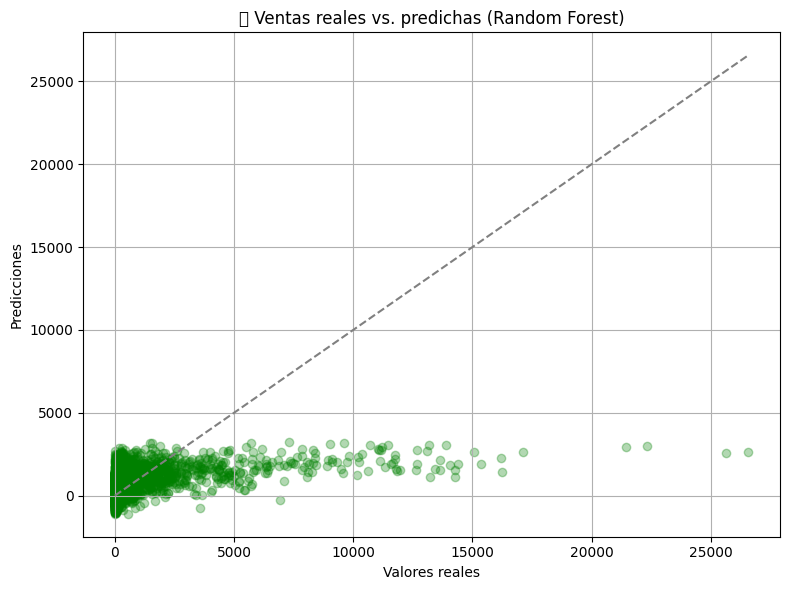

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3, color="green")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--", color="gray")
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("🎯 Ventas reales vs. predichas (Random Forest)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Random Forest Regression

In [ ]:
# Train a more powerful model: Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,  # Number of trees
    max_depth=10,       # Maximum depth of the trees
    random_state=42     # For reproducibility
)
rf_model.fit(X_train, y_train)

# Predictions on training data
y_pred_rf = rf_model.predict(X_train)

# Evaluation on training data
print("🌲 Random Forest Results (TRAIN):")
print("📈 RMSE:", mean_squared_error(y_train, y_pred_rf))
print("📉 R2:", r2_score(y_train, y_pred_rf))

# Predictions on test data
y_pred_rf = rf_model.predict(X_test)

# Evaluation on test data
print("🌲 Random Forest Results (TEST):")
print("📈 RMSE:", mean_squared_error(y_test, y_pred_rf))
print("📉 R2:", r2_score(y_test, y_pred_rf))

🌲 Random Forest Results (TRAIN):
📈 RMSE: 887785.3353752845
📉 R2: 0.7220464506982858
🌲 Random Forest Results (TEST):
📈 RMSE: 2130723.050414317
📉 R2: 0.34219201129547094


<ipython-input-128-97ccb63d17b3>:8: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


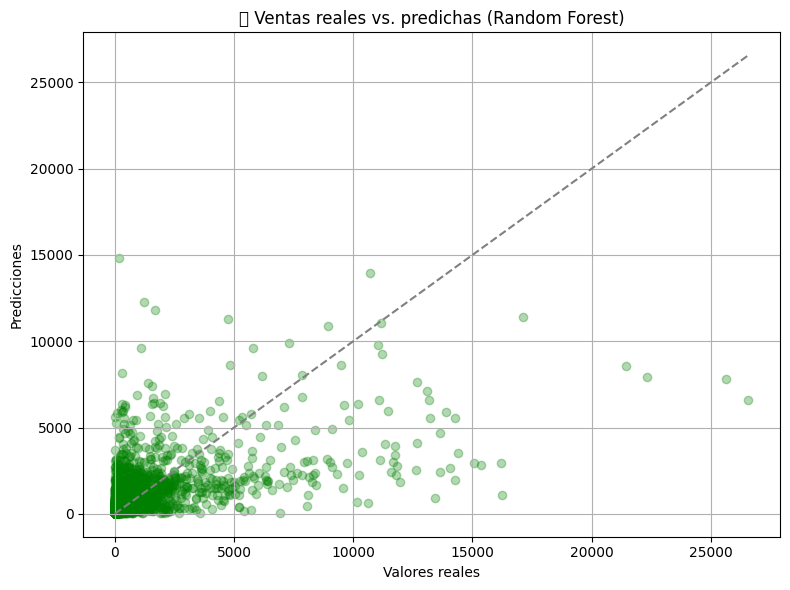

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.3, color="green")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--", color="gray")
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("🎯 Ventas reales vs. predichas (Random Forest)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Create a DataFrame with results
results_df = pd.DataFrame({
    "Real": y_test.values,  # Actual values from the test set
    "Prediction": y_pred_rf  # Predicted values from the model
})

# Round the values for better visualization
results_df["Real"] = results_df["Real"].round(0).astype(int)  # Round actual values
results_df["Prediction"] = results_df["Prediction"].round(0).astype(int)  # Round predicted values

# Show the first few rows
print("🔍 Predictions vs. Actual Values:")
print(results_df.head(15).to_string(index=False))  # Display first 15 rows without index

🔍 Predictions vs. Actual Values:
 Real  Prediction
 4465        1476
    3         262
   36         463
   28          95
    2          59
   21          45
    9         120
    5         129
  119          89
    4         160
    3         437
    7          41
 3408         220
    4         144
   20          45


## Artificial Neural Networks

In [ ]:
# Features and target
X = df_pd[["platform_index", "genres_index", "developers_index", "publishers_index", "supported_languages", "usd", "release_year"]].values
y = df_pd["sales_volume"].values.reshape(-1, 1)

# Scale features and target for better training performance
scaler_X = StandardScaler()  # Initialize scaler for features
scaler_y = StandardScaler()  # Initialize scaler for target
X_scaled = scaler_X.fit_transform(X)  # Scale the features
y_scaled = scaler_y.fit_transform(y)  # Scale the target

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)  # Convert features to tensor
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)  # Convert target to tensor

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)  # 70% train, 30% test

In [ ]:
class RegressionNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Sequential(
            nn.Linear(7, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.hidden(x)

model = RegressionNN()

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training
epochs = 2000
for epoch in range(epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"🧪 Epoch {epoch} - Loss: {loss.item():.4f}")

🧪 Epoch 0 - Loss: 1.0029
🧪 Epoch 20 - Loss: 0.7234
🧪 Epoch 40 - Loss: 0.6770
🧪 Epoch 60 - Loss: 0.6381
🧪 Epoch 80 - Loss: 0.5990
🧪 Epoch 100 - Loss: 0.5653
🧪 Epoch 120 - Loss: 0.5391
🧪 Epoch 140 - Loss: 0.5250
🧪 Epoch 160 - Loss: 0.5036
🧪 Epoch 180 - Loss: 0.4852
🧪 Epoch 200 - Loss: 0.4814
🧪 Epoch 220 - Loss: 0.4719
🧪 Epoch 240 - Loss: 0.4599
🧪 Epoch 260 - Loss: 0.4472
🧪 Epoch 280 - Loss: 0.4509
🧪 Epoch 300 - Loss: 0.4290
🧪 Epoch 320 - Loss: 0.4277
🧪 Epoch 340 - Loss: 0.4161
🧪 Epoch 360 - Loss: 0.4107
🧪 Epoch 380 - Loss: 0.4019
🧪 Epoch 400 - Loss: 0.4062
🧪 Epoch 420 - Loss: 0.3934
🧪 Epoch 440 - Loss: 0.3980
🧪 Epoch 460 - Loss: 0.3796
🧪 Epoch 480 - Loss: 0.3767
🧪 Epoch 500 - Loss: 0.3891
🧪 Epoch 520 - Loss: 0.3669
🧪 Epoch 540 - Loss: 0.3839
🧪 Epoch 560 - Loss: 0.3551
🧪 Epoch 580 - Loss: 0.3525
🧪 Epoch 600 - Loss: 0.3507
🧪 Epoch 620 - Loss: 0.3513
🧪 Epoch 640 - Loss: 0.3517
🧪 Epoch 660 - Loss: 0.3413
🧪 Epoch 680 - Loss: 0.3371
🧪 Epoch 700 - Loss: 0.3375
🧪 Epoch 720 - Loss: 0.3314
🧪 Epoch

In [ ]:
# Set the model to evaluation mode (turn off dropout, etc.)
model.eval()

# Disable gradient calculations to improve efficiency during inference
with torch.no_grad():
    # Generate predictions using the trained model
    predictions = model(X_train)

# Inverse the scaling to get real values back
y_pred_nn = scaler_y.inverse_transform(predictions.numpy())  # Inverse transform of predicted values
y_train_real = scaler_y.inverse_transform(y_train.numpy())  # Inverse transform of actual values

# Calculate RMSE (Root Mean Squared Error)
rmse_nn = mean_squared_error(y_train_real, y_pred_nn)

# Calculate R² (Coefficient of Determination)
r2_nn = r2_score(y_train_real, y_pred_nn)

# Print the evaluation results for the training set
print("ANN Results (TRAIN):")
print(f"📈 RMSE (Neural Network): {rmse_nn:.2f}")
print(f"📉 R² (Neural Network): {r2_nn:.4f}")

ANN Results (TRAIN):
📈 RMSE (Neural Network): 861174.12
📉 R² (Neural Network): 0.7304


In [ ]:
# Set the model to evaluation mode (turn off dropout, etc.)
model.eval()

# Disable gradient calculations to improve efficiency during inference
with torch.no_grad():
    # Generate predictions using the trained model on the test set
    predictions = model(X_test)

# Inverse the scaling to get real values back
y_pred_nn = scaler_y.inverse_transform(predictions.numpy())  # Inverse transform of predicted values
y_test_real = scaler_y.inverse_transform(y_test.numpy())  # Inverse transform of actual values

# Calculate RMSE (Root Mean Squared Error) for the test set
rmse_nn = mean_squared_error(y_test_real, y_pred_nn)

# Calculate R² (Coefficient of Determination) for the test set
r2_nn = r2_score(y_test_real, y_pred_nn)

# Print the evaluation results for the test set
print("ANN Results (TEST):")
print(f"📈 RMSE (Neural Network): {rmse_nn:.2f}")
print(f"📉 R² (Neural Network): {r2_nn:.4f}")

ANN Results (TEST):
📈 RMSE (Neural Network): 4448407.00
📉 R² (Neural Network): -0.3733


In [ ]:
# Create a DataFrame to compare real values vs predicted values for the neural network model
results_nn = pd.DataFrame({
    "Real": y_test_real.flatten().round(0).astype(int),  # Round and convert the real values to integers
    "Predicción": y_pred_nn.flatten().round(0).astype(int)  # Round and convert the predicted values to integers
})

# Print the comparison for the first 15 predictions
print("🔮 Neural Network - Predictions vs. Real Values:")
print(results_nn.head(15).to_string(index=False))  # Display the first 15 rows without the index

🔮 Neural Network - Predictions vs. Real Values:
 Real  Predicción
 4465        2396
    3         482
   36         176
   28         409
    2          -6
   21         176
    9          37
    5         -40
  119         371
    4          96
    3        1895
    7         153
 3408         442
    4         169
   20         312


<ipython-input-136-2b3d3721a6f7>:9: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


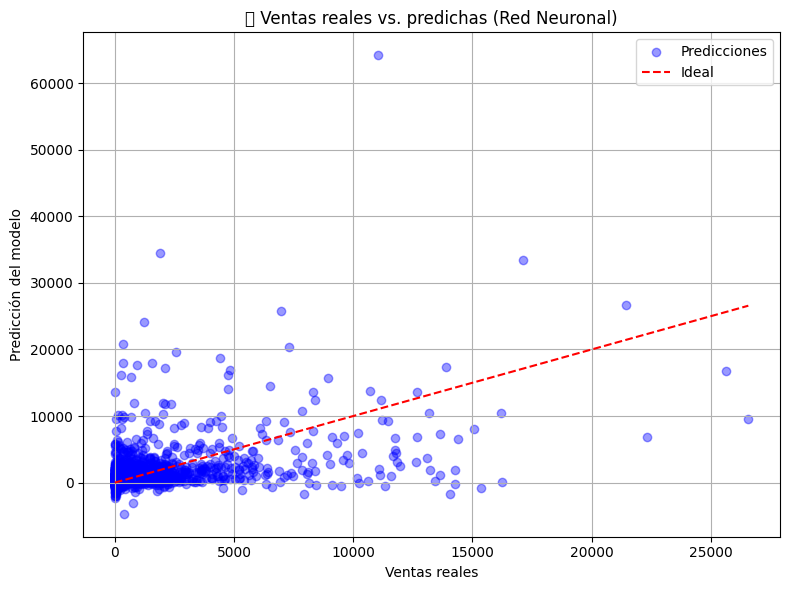

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_real, y_pred_nn, alpha=0.4, color="blue", label="Predicciones")
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], '--', color='red', label="Ideal")
plt.xlabel("Ventas reales")
plt.ylabel("Predicción del modelo")
plt.title("🎯 Ventas reales vs. predichas (Red Neuronal)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# DATA ANALYSIS TASK 2: Data Visualization

The second data analysis task focuses on data visualization using Principal Component Analysis (PCA). We used PCA to reduce the dimensionality of the dataset and project the data onto the first two principal components. These two components together account for 40% of the total explained variance, meaning that they represent a substantial portion of the variability in the dataset, but there is still much more variance captured by the remaining components.

After plotting the data above the plane defined by the first two principal components, we observed a clear pattern in the data:

- **Two distinct clusters:** The data points form two dense clusters, or "balls," that are clearly separated from each other. This suggests that the dataset naturally splits into two main groups of games with distinct characteristics.

- **Outliers:** In addition to the two main clusters, we noticed the presence of outliers—data points that fall outside the area defined by the dense clusters. These outliers represent games that are distinct from the others, possibly due to unique attributes or anomalies in the data.

To try to identify what differentiates these two clusters, we used the type of developers (as one of the categorical variables) to categorize the data points. However, upon analyzing the plot, we did not observe any discernible pattern related to the type of developers. The data points belonging to any type of developer appeared across both clusters, meaning there is no clear relationship between the type of developer and the clusters defined by the principal components.

In [ ]:
# Step 1: Extract the year from the 'release_date' column
df = df_final.withColumn("release_year", year("release_date"))

# Step 2: Index categorical variables
# StringIndexer is used to convert categorical variables into numerical indices
platform_indexer = StringIndexer(inputCol="platform", outputCol="platform_index")
genres_indexer = StringIndexer(inputCol="genres", outputCol="genres_index")
developers_indexer = StringIndexer(inputCol="type_developers", outputCol="developers_index")
publishers_indexer = StringIndexer(inputCol="type_publishers", outputCol="publishers_index")

# Step 3: Apply StringIndexers to the DataFrame
# Apply each indexer and update the DataFrame with new indexed columns
df = platform_indexer.fit(df).transform(df)
df = genres_indexer.fit(df).transform(df)
df = developers_indexer.fit(df).transform(df)
df = publishers_indexer.fit(df).transform(df)

# Step 4: Select final columns for the model
# The selected columns will be used in the machine learning model
df = df.select(
    "platform_index",         # Index for platform
    "genres_index",           # Index for genres
    "developers_index",       # Index for developers type
    "publishers_index",       # Index for publishers type
    "supported_languages",    # Number of supported languages
    "usd",                    # USD price
    "release_year",           # Year of release
    "sales_volume"            # Sales volume
)

In [ ]:
df_pd = df.toPandas()

In [ ]:
# Assume df_pd is your DataFrame
# If 'genre' is the column with game genres, make sure to drop it before scaling
X = df_pd.drop(columns=['developers_index'])

# Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [ ]:
pca.explained_variance_ratio_

array([0.2254117 , 0.18926906])

In [ ]:
# Create a DataFrame with the PCA projections and the 'genre' column
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_pca['developers'] = df_pd['developers_index']

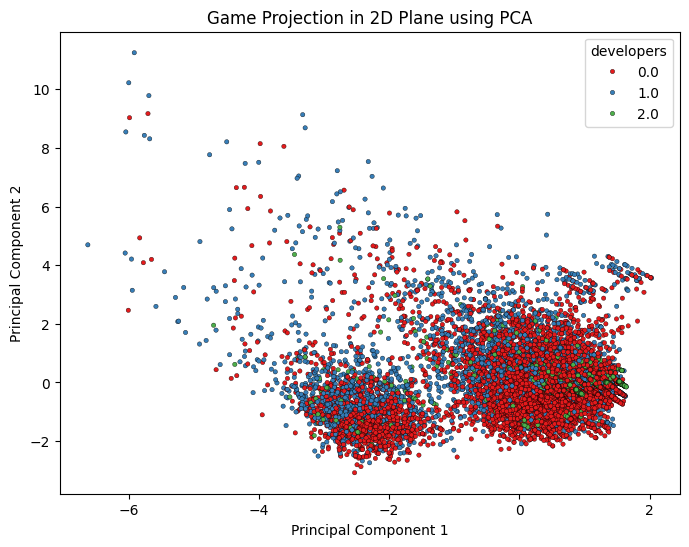

In [ ]:
# Create the plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='developers', data=df_pca, palette='Set1', s=10, edgecolor='black')

# Adjust title and labels
plt.title('Game Projection in 2D Plane using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Show the plot
plt.show()

# DATA ANALYSIS TASK3: Variable visualization

Finally, we examined the distribution of sales_volume across different game genres to identify which genres perform best in terms of sales. This analysis provides valuable insights for game developers, marketers, and analysts to understand which genres are most popular or generate the highest sales.

We discovered that Action and Adventure genres consistently lead in total sales volume, reflecting their strong presence in the market, likely due to their broad appeal and the success of major games within these categories.

However, when we normalized the sales volume by the number of games in each genre, genres like Shooter and Free-to-Play emerged as having potentially higher sales volumes per game, indicating that although these genres may have fewer games, the ones that do exist tend to perform exceptionally well.

In [ ]:
# Aggregate total sales by genre
genre_sales = df_final.groupBy("genres").sum("sales_volume").withColumnRenamed("sum(sales_volume)", "total_sales")
genre_count = df_final.groupBy("genres").count()

genre_sales = genre_sales.join(genre_count, "genres")
genre_sales = genre_sales.withColumn("rel_sales", genre_sales["total_sales"] / genre_sales["count"])
# Show the results of total sales by genre
genre_sales.show()  # Display the total sales by genre

+--------------------+-----------+-----+------------------+
|              genres|total_sales|count|         rel_sales|
+--------------------+-----------+-----+------------------+
|          management|    29791.0|  318| 93.68238993710692|
|first person shooter|   414532.0|  400|           1036.33|
|             shooter|   648643.0|  203| 3195.285714285714|
|          turn based|    96405.0|  561|171.84491978609626|
|third person shooter|   465119.0|  233|1996.2188841201717|
|        "beat em up"|   104115.0|  171|  608.859649122807|
|          collection|    46713.0|  133|351.22556390977445|
|        card & board|    26820.0|  133|201.65413533834587|
|    vehicular combat|    37670.0|  105|358.76190476190476|
|              action|  1019278.0| 1435| 710.2982578397213|
|        free to play|   250241.0|  105| 2383.247619047619|
|      music & rhythm|    28439.0|  122|233.10655737704917|
|    action-adventure|   348384.0|  489| 712.4417177914111|
|     survival horror|    17800.0|  114|

In [ ]:
# Convert the result to a Pandas DataFrame for easier viewing and further processing
genre_sales_pd = genre_sales.toPandas()

# Check the first few records to verify the result
genre_sales_pd.head()  # Display the top rows of the genre sales DataFrame

,genres,total_sales,count,rel_sales
0,management,29791.0,318,93.682390
1,first person shooter,414532.0,400,1036.330000
2,shooter,648643.0,203,3195.285714
3,turn based,96405.0,561,171.844920
4,third person shooter,465119.0,233,1996.218884


<ipython-input-174-31dc3af30a41>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='genres', y='total_sales', data=genre_sales_pd, palette='viridis')  # Create the bar plot with color palette


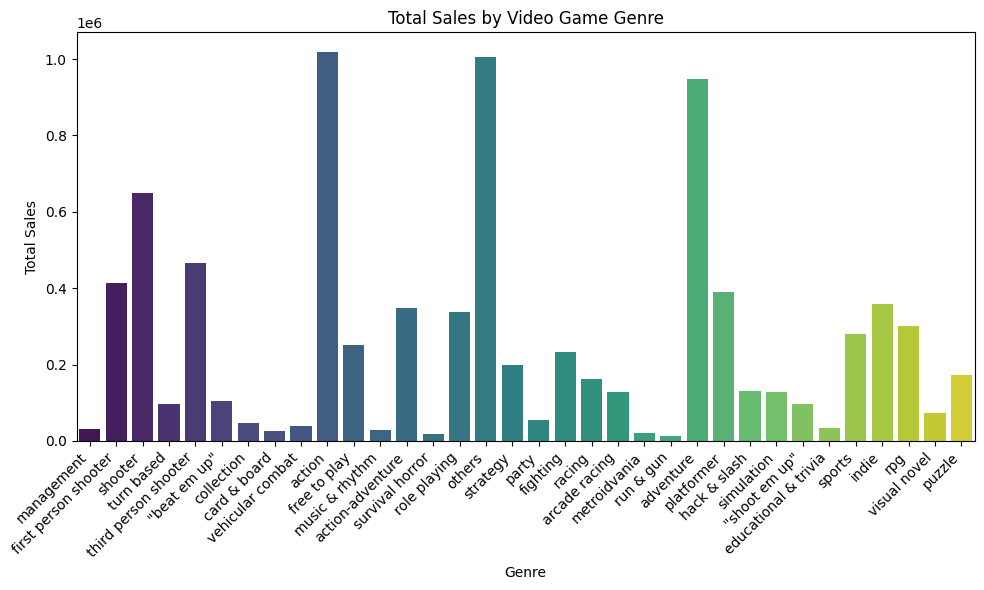

In [ ]:
# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))  # Set the size of the figure
sns.barplot(x='genres', y='total_sales', data=genre_sales_pd, palette='viridis')  # Create the bar plot with color palette

# Add labels and title to the plot
plt.xlabel('Genre')  # X-axis label
plt.ylabel('Total Sales')  # Y-axis label
plt.title('Total Sales by Video Game Genre')  # Title of the chart
plt.xticks(rotation=45, ha='right')  # Rotate X-axis labels for better visibility

# Show the plot
plt.tight_layout()  # Adjust layout to ensure everything fits without overlap
plt.show()  # Display the plot

<ipython-input-173-2f0ee86dca6f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='genres', y='rel_sales', data=genre_sales_pd, palette='viridis')  # Create the bar plot with color palette


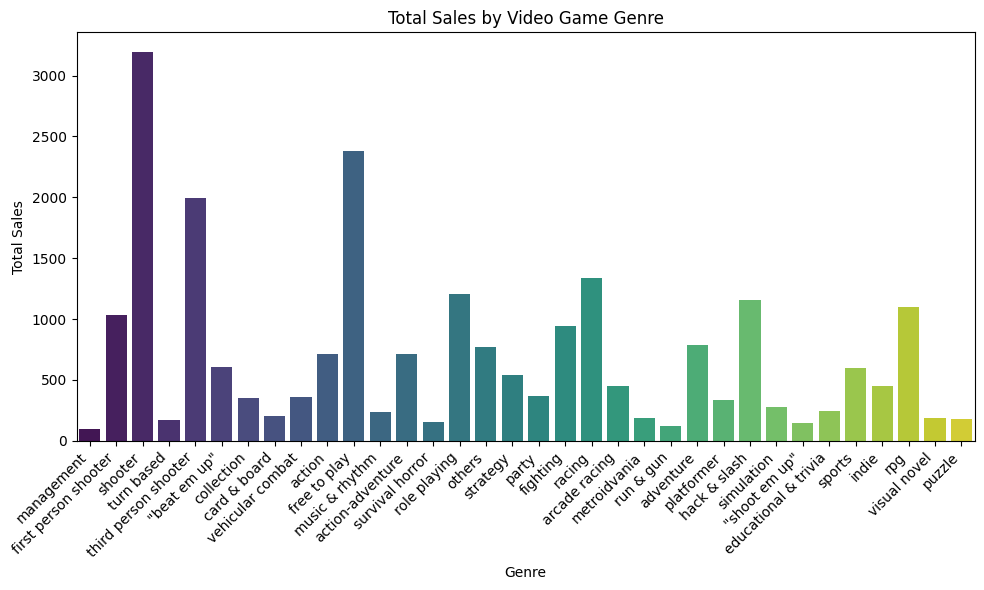

In [ ]:
# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))  # Set the size of the figure
sns.barplot(x='genres', y='rel_sales', data=genre_sales_pd, palette='viridis')  # Create the bar plot with color palette

# Add labels and title to the plot
plt.xlabel('Genre')  # X-axis label
plt.ylabel('Total Sales')  # Y-axis label
plt.title('Total Sales by Video Game Genre')  # Title of the chart
plt.xticks(rotation=45, ha='right')  # Rotate X-axis labels for better visibility

# Show the plot
plt.tight_layout()  # Adjust layout to ensure everything fits without overlap
plt.show()  # Display the plot